In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')
import random

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib.ticker import MultipleLocator

from util import array2mat

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
map_info = pd.read_csv('/lmh_data/data/sclab/sclab/map_result.csv', sep='\t', index_col=0)
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})

gene_name = 'MBP'
eval_set = np.load('/lmh_data/data/sclab/sclab/Mb/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/Mb/tmp/{}/evaluate.npy'.format(gene_name), allow_pickle=True)

In [3]:
rna = rna[map_info.index]
rna = rna[rna.obs['cell_type'].isin(['ODC']),:]
rna.layers["counts"] = rna.X.copy()

In [4]:
_index = []
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
#     if eval_set[i]['cell_type'] in ['Endo']:
#         continue
    if eval_set[i]['cell_type'] not in ['ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            _index.append(_rna[j].obs.index[0])
            
rna = rna[_index]
rna

View of AnnData object with n_obs × n_vars = 210 × 50281
    obs: 'cell_type', 'domain'
    layers: 'counts'

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be

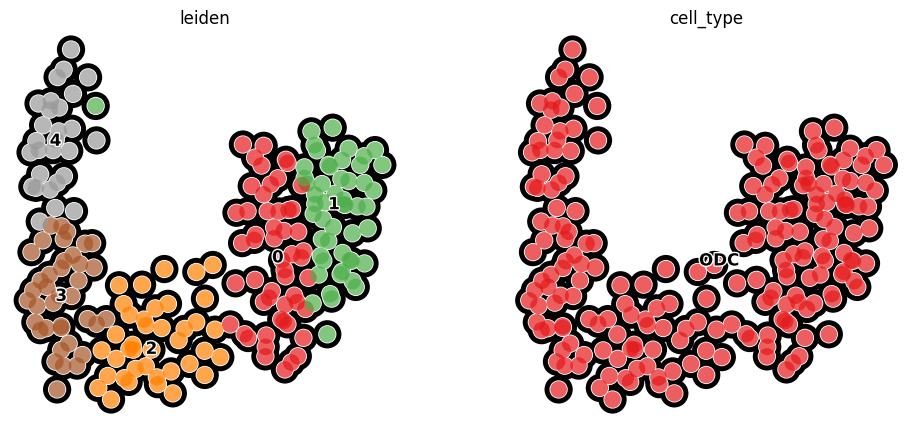

In [5]:
rna.X = rna.layers["counts"].copy()
# sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
# sc.pp.normalize_total(rna)
# sc.pp.log1p(rna)
# sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.tl.leiden(rna)

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

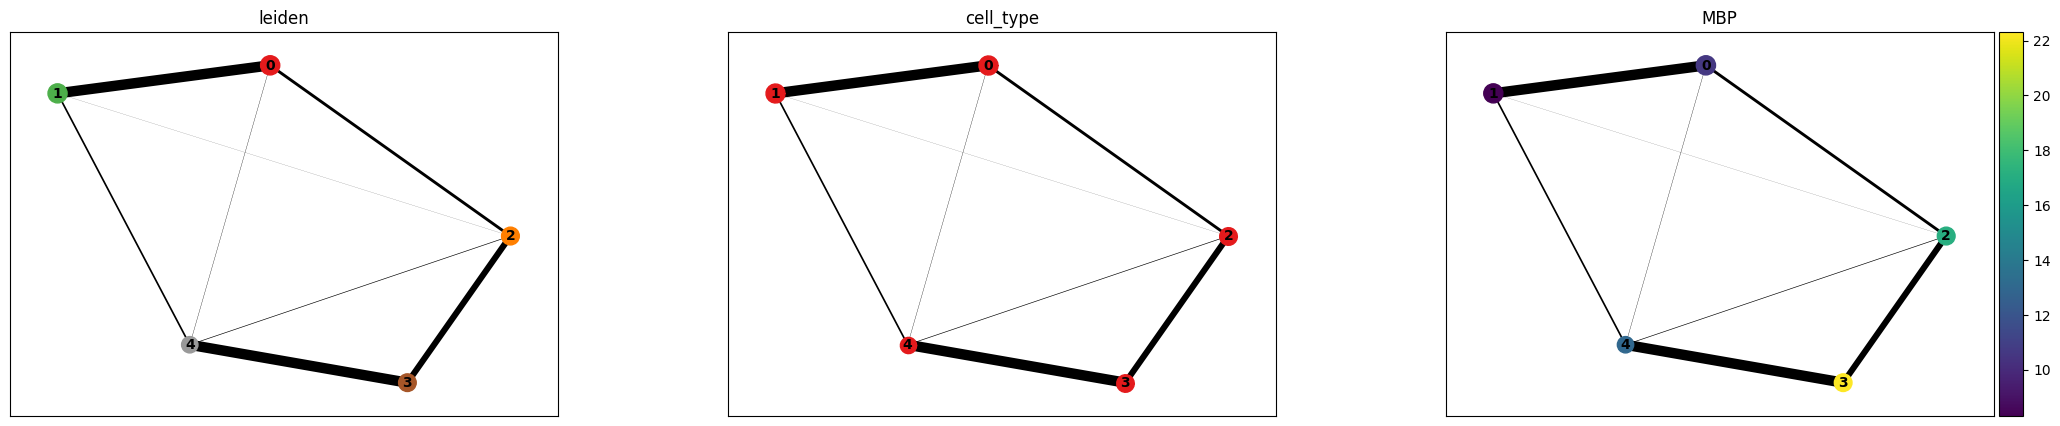

In [6]:
sc.tl.paga(rna, groups='leiden')
sc.pl.paga(rna, color=['leiden', 'cell_type', gene_name])

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


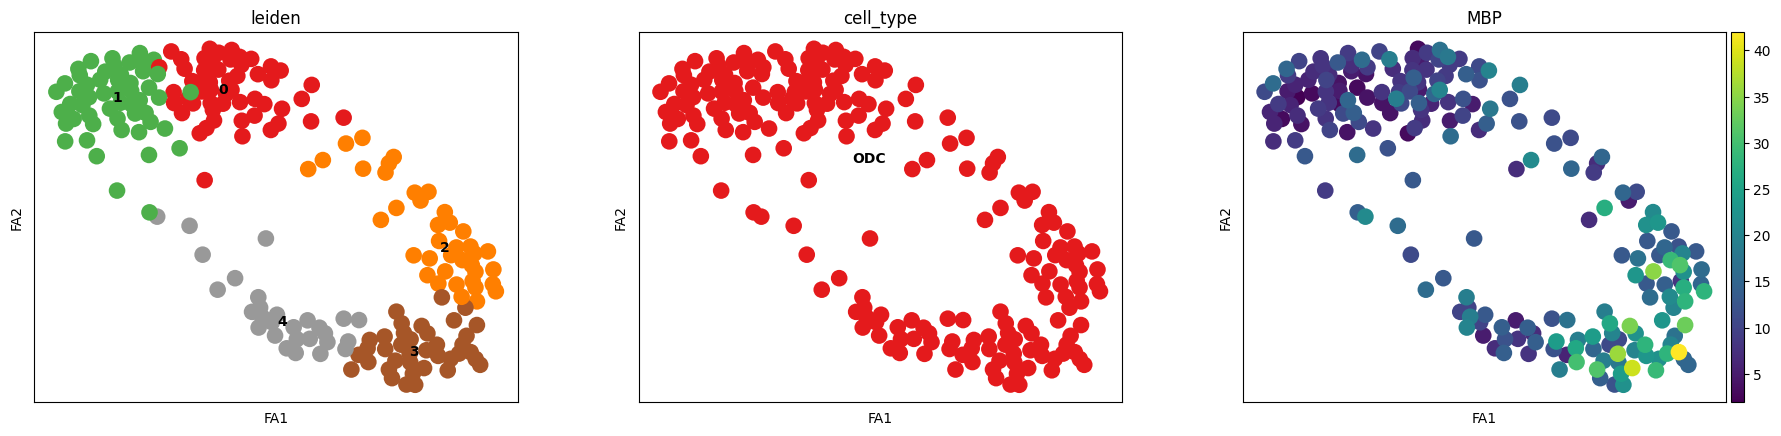

In [7]:
sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', gene_name], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


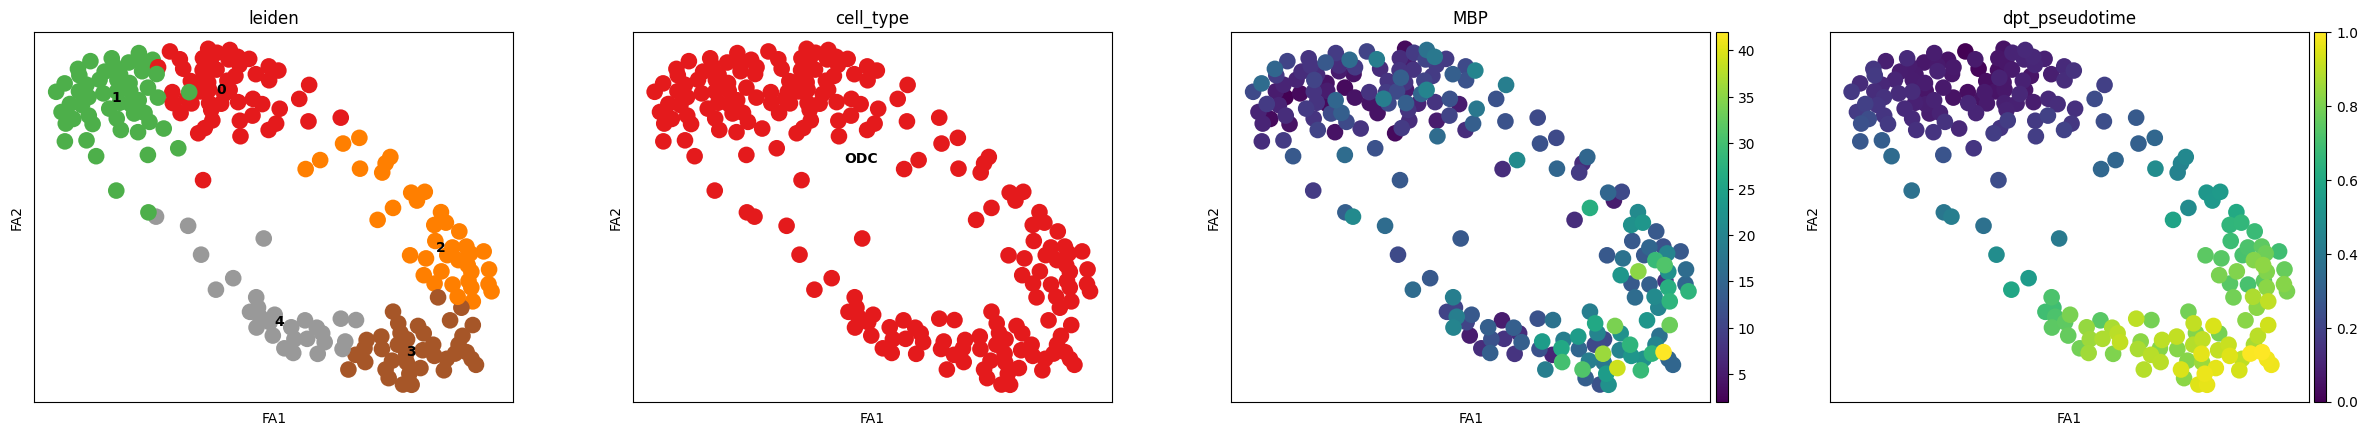

In [8]:
rna.uns['iroot'] = np.flatnonzero(rna.obs['leiden']=='0')[0]
sc.tl.dpt(rna)

sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', gene_name, 'dpt_pseudotime'], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


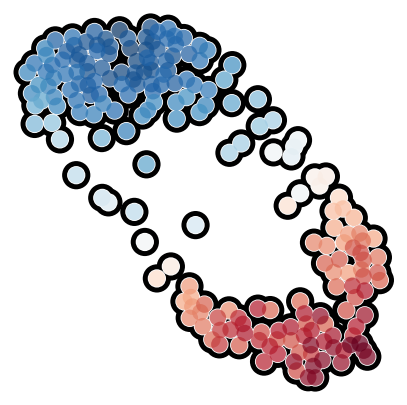

In [9]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.draw_graph(rna, color=['dpt_pseudotime'], cmap='RdBu_r',
                     add_outline=True, legend_loc=None, colorbar_loc=None, title='', frameon=False, return_fig=True)
#     plt.savefig(
#         '/lmh_data/work/SEE/analyse/figure_file/pseudotime({}).pdf'.format(gene_name),
#         format='pdf', bbox_inches='tight')
    plt.show()

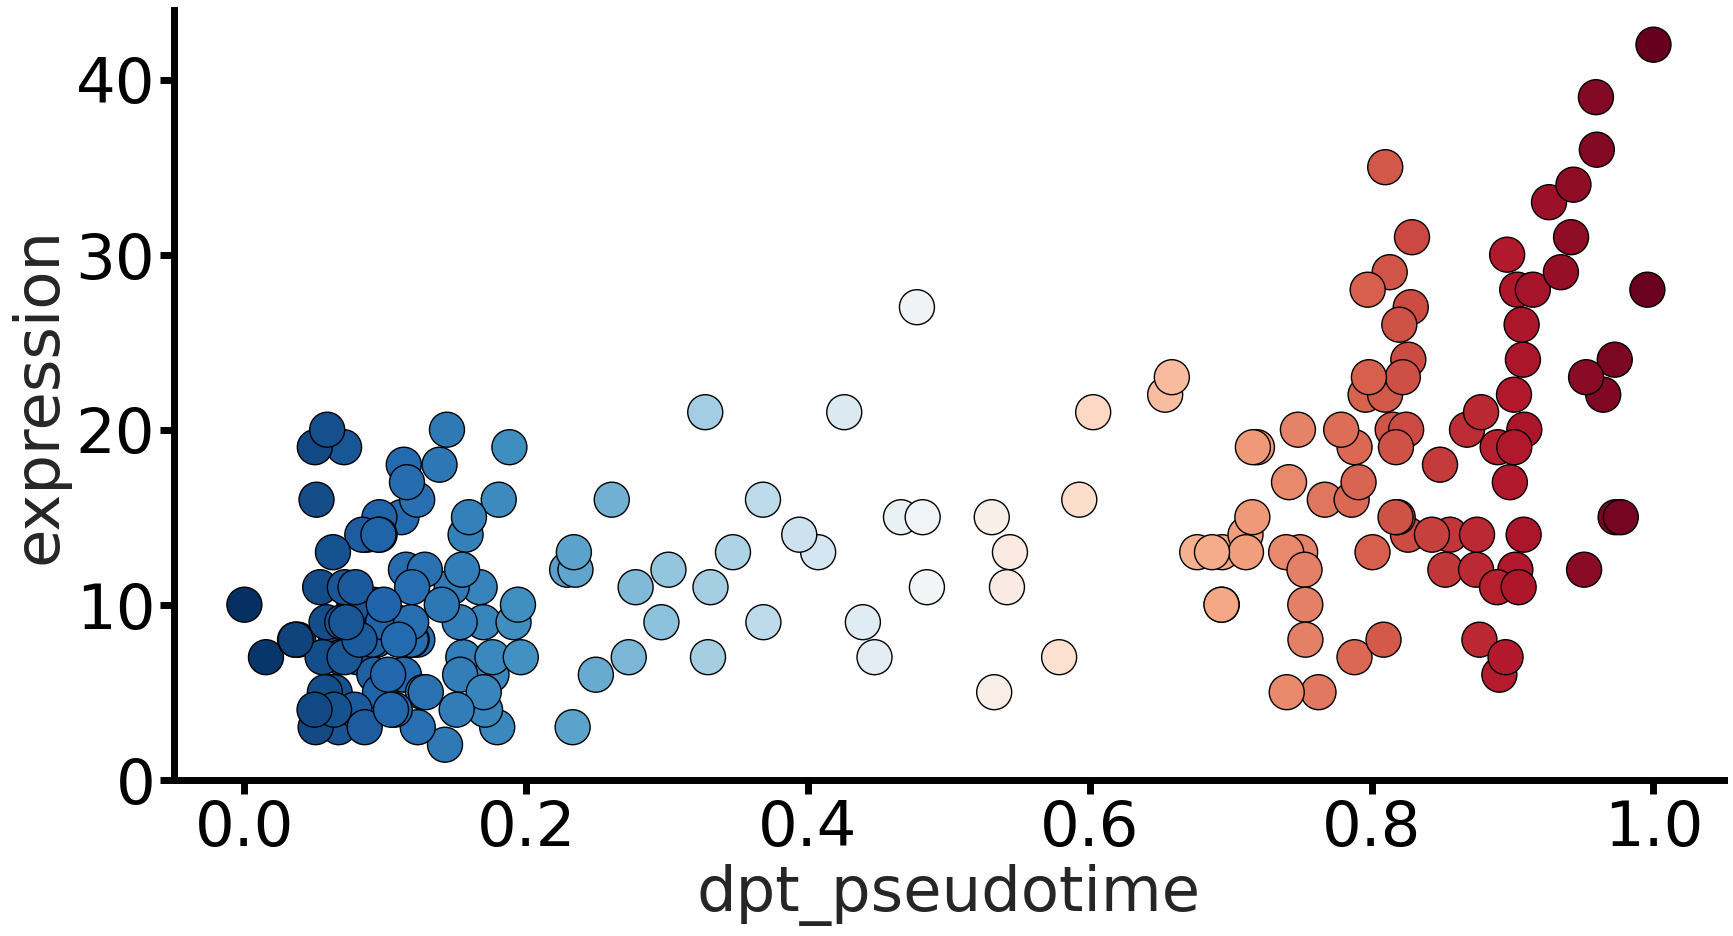

In [10]:
import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

set_plt(figsize=(20, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

_x, _y = rna.obs['dpt_pseudotime'].values, rna[:, gene_name].layers["counts"].reshape(-1)
ax.scatter(_x, _y, edgecolors='black', s=(figure_size['large']*72./fig.dpi)**2, c=_x, cmap='RdBu_r')

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
plt.xlabel('dpt_pseudotime', fontsize=figure_size['ultra'])
plt.ylabel('expression', fontsize=figure_size['ultra'])
# plt.savefig(
#     '/lmh_data/work/SEE/analyse/figure_file/{} expression(ODC).pdf'.format(gene_name),
#     format='pdf', bbox_inches='tight')
plt.show()

In [11]:
scHiC = {}
target_scHiC = {}
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in ['ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            scHiC[_rna[j].obs_names[0]] = preds[i]['predict']
            target_scHiC[_rna[j].obs_names[0]] = eval_set[i]['scHiC'][gene_name]
            break
scHiC

{'CTACAGATCACTTTGT-LKTX_190130_01_G01': array([0.41716754 , 0.044146273, 0.009493066, ..., 0.39696938 ,
        0.022519823, 0.37265804 ], dtype=float32),
 'TCCCAGTAGATACCAA-LKTX_190130_01_G01': array([0.38821286 , 0.03514241 , 0.011330048, ..., 0.36221674 ,
        0.008582862, 0.34021446 ], dtype=float32),
 'AGCGATTCAGGTGAGT-LKTX_190129_01_B01': array([0.34016973 , 0.039907027, 0.007943442, ..., 0.3112129  ,
        0.012561111, 0.30164835 ], dtype=float32),
 'ATAGAGATCCGATTAG-LKTX_190130_01_F01': array([0.35413754 , 0.03420774 , 0.001495786, ..., 0.32114682 ,
        0.010028098, 0.313211   ], dtype=float32),
 'TCATGGACAACTGCTA-LKTX_190130_01_H01': array([0.3268034   , 0.038702745 , 0.0067393426, ..., 0.29865316  ,
        0.014563646 , 0.28746778  ], dtype=float32),
 'GAGCCTGTCGTCAACA-LKTX_190130_01_H01': array([0.37602714 , 0.037084315, 0.005268663, ..., 0.3316592  ,
        0.014948541, 0.34195524 ], dtype=float32),
 'GGGATCCAGAGCCGTA-LKTX_190130_01_G01': array([0.45995805 , 0.03

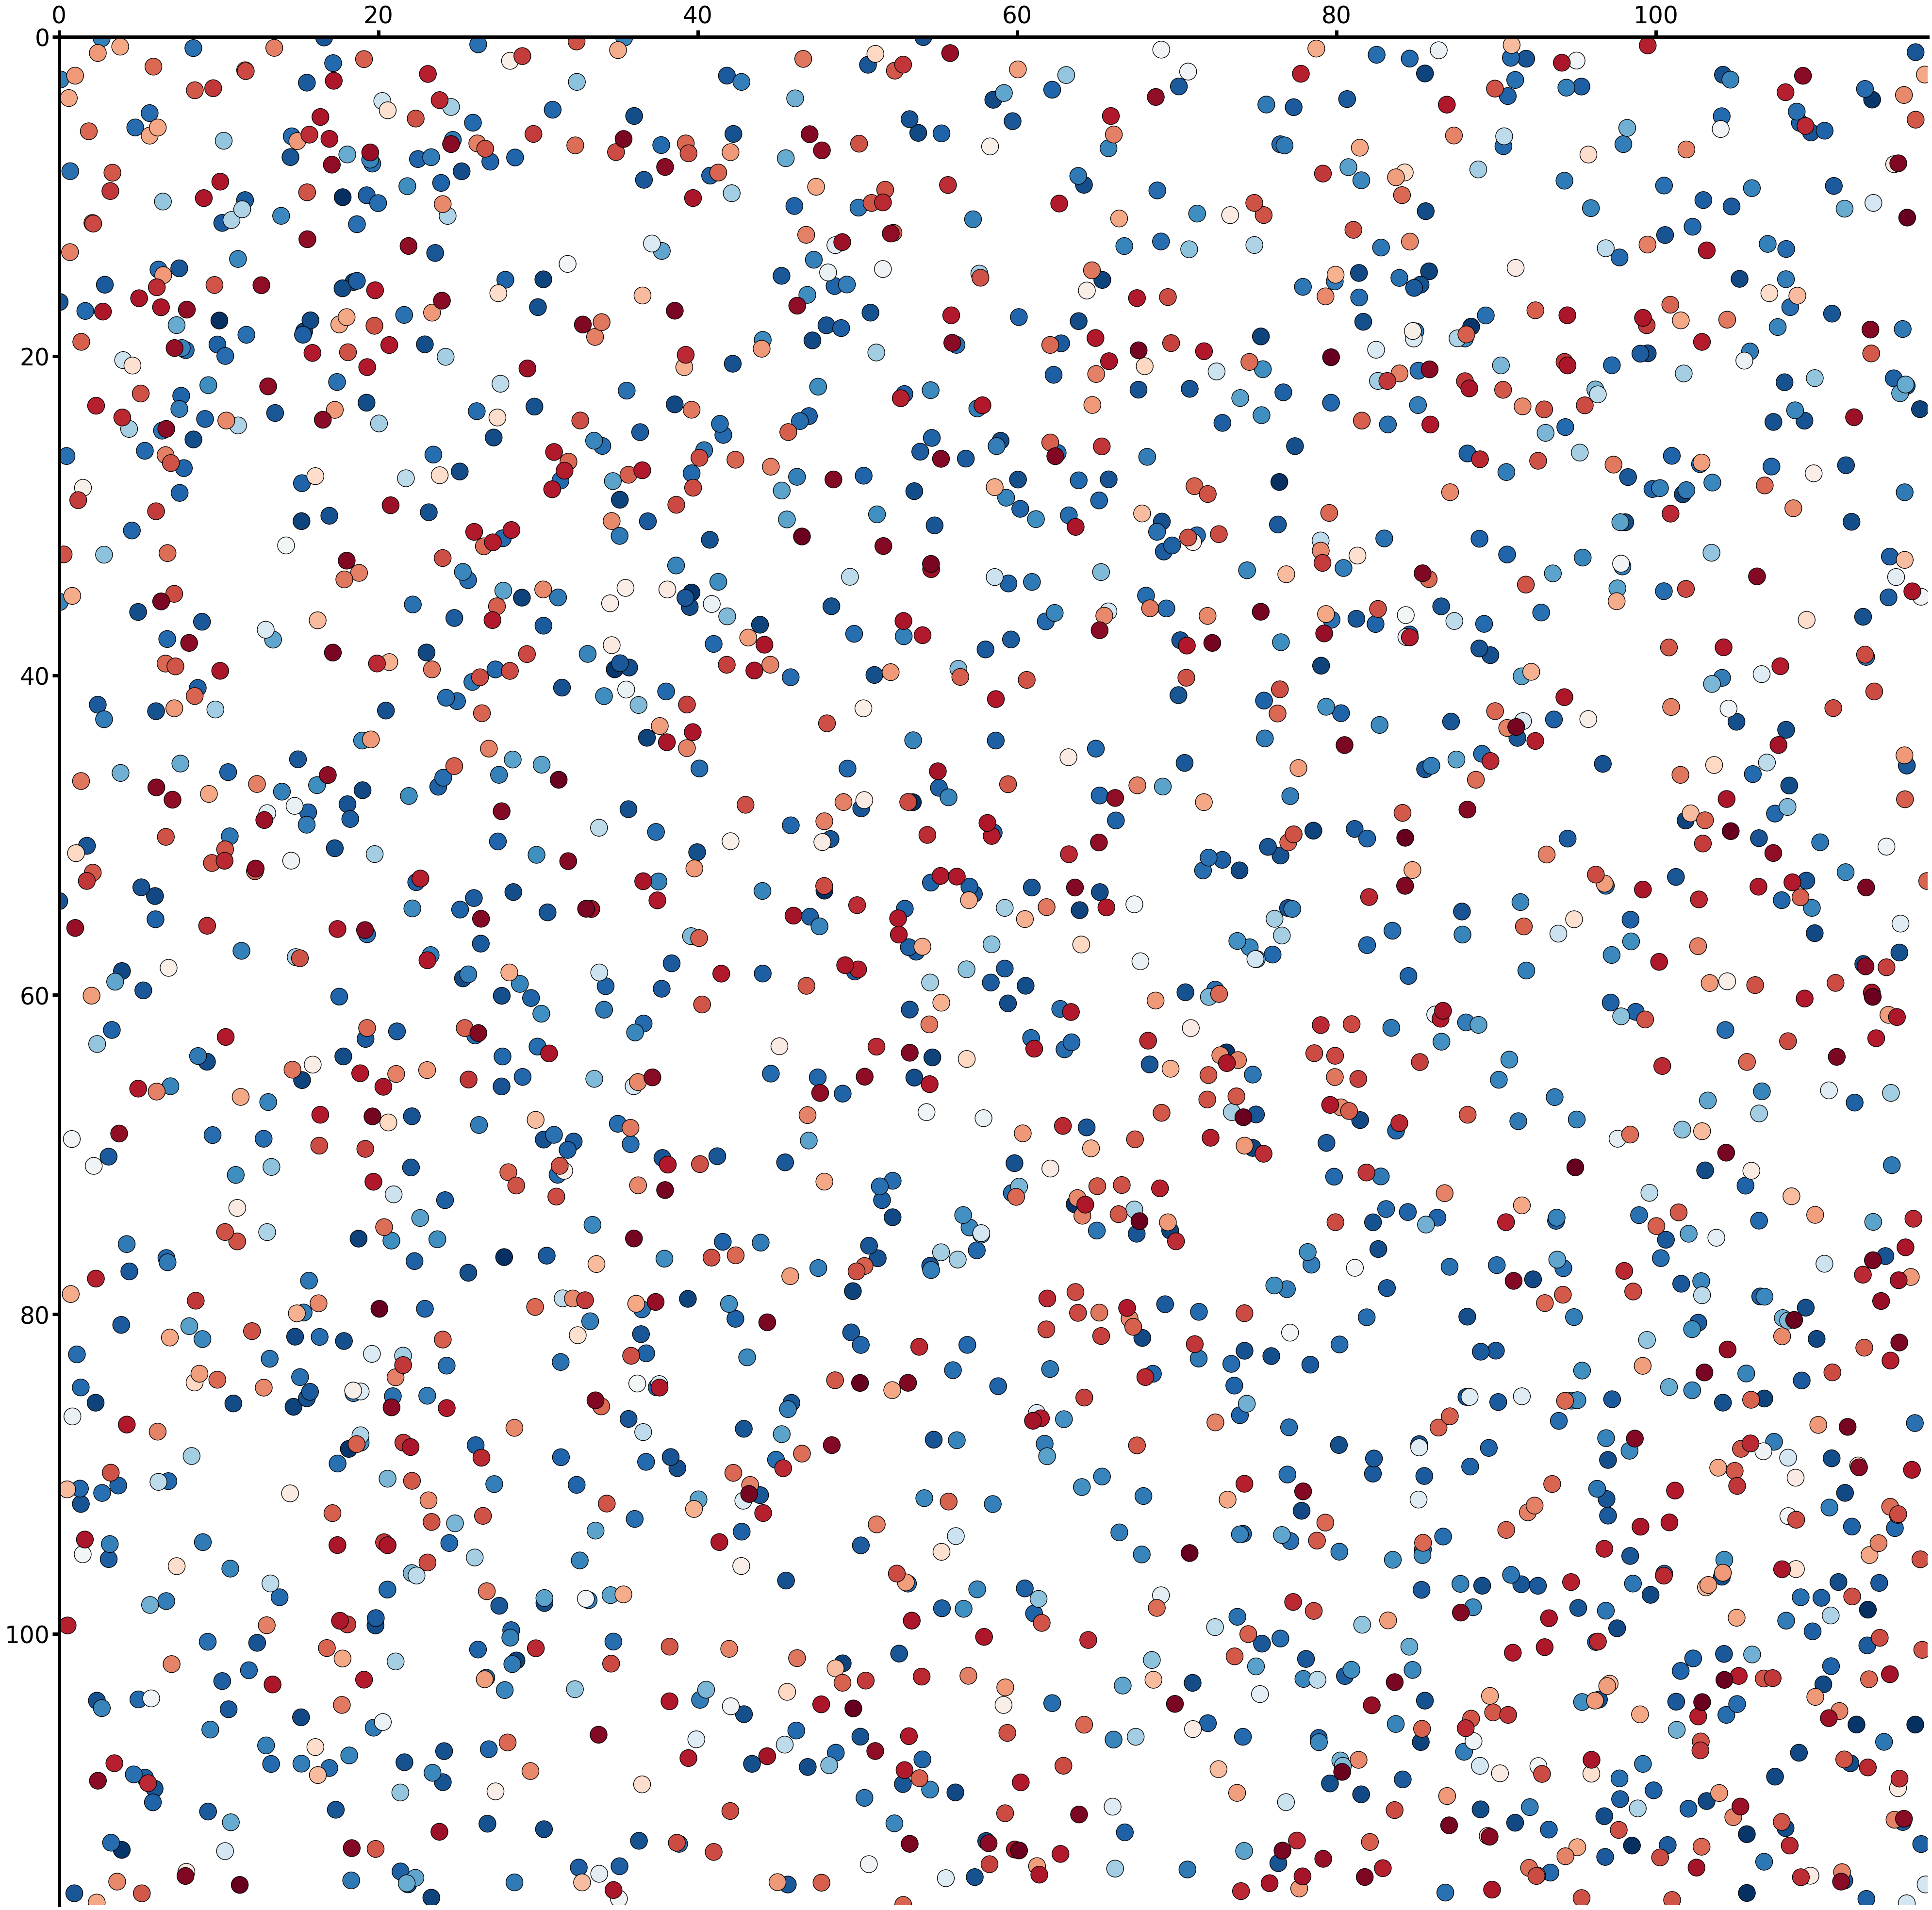

In [12]:
set_plt(figsize=(50, 50))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
set_Border(plt.gca())

_len = array2mat(scHiC.get(next(iter(scHiC)))).shape[0]

_scatter_xs, _scatter_ys = [], []
_pseudotimes = []
_rna_names = []
for rna_name in rna.obs.sort_values(by='dpt_pseudotime').index:
    if rna_name not in scHiC.keys():
        continue
    _pseudotime = rna[rna_name].obs['dpt_pseudotime'].values[0]
    _hic = array2mat(scHiC[rna_name]).copy()
    _hic += abs(_hic.min())
    
    _where = np.where(np.ones(_hic.shape))
    _where = list(zip(_where[0], _where[1]))
    _test = np.zeros(len(_where), dtype=object)
    for i in range(len(_where)):
        _test[i] = _where[i]
    _where = _test
    _p = np.triu(_hic, 1).reshape(-1)
    _p /= _p.sum()

    _scatter_x, _scatter_y = [], []
    for (i, j) in np.random.choice(_where, max(1, int(_len/20)), p=_p):
        _i, _j = random.random()+i, random.random()+j
        if i == j:
            _i, _j = max(_i, _j), min(_i, _j)
        _scatter_x.append(_i)
        _scatter_y.append(_j)

    _i, _j = _scatter_x.copy(), _scatter_y.copy()
    _scatter_x.extend(_j), _scatter_y.extend(_i)

    _scatter_xs.extend(_scatter_x), _scatter_ys.extend(_scatter_y)
    _pseudotimes.extend([_pseudotime]*len(_scatter_x))
    _rna_names.extend([rna_name]*len(_scatter_x))

plt.scatter(_scatter_xs, _scatter_ys, edgecolors='black',
            s=(figure_size['large']*72./fig.dpi)**2, c=_pseudotimes, cmap='RdBu_r')

plt.xticks([i for i in range(_len)])
plt.yticks([i for i in range(_len)])
plt.xlim((0, _len))
plt.ylim((0, _len))

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('none')
ax.spines['top'].set_linewidth(figure_size['very_small'])

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')

ax.xaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_locator(MultipleLocator(20))

plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['large'])
plt.grid(False)
# plt.savefig(
#     '/lmh_data/work/SEE/analyse/figure_file/{} heatmap(ODC).pdf'.format(gene_name),
#     format='pdf', bbox_inches='tight')
plt.show()

In [13]:
_partition = [
    rna.obs[rna.obs.dpt_pseudotime<=0.5],
    rna.obs[rna.obs.dpt_pseudotime>0.5]
]

pseudo_bulk_hic = []

for i in range(len(_partition)):
    _pseudo_bulk = None
    for rna_name in _partition[i].index:
        if rna_name not in scHiC.keys():
            continue

        _hic = array2mat(scHiC[rna_name]).copy()
        _hic += abs(_hic.min())
        if _pseudo_bulk is None:
            _pseudo_bulk = _hic
        else:
            _pseudo_bulk += _hic

    pseudo_bulk_hic.append(_pseudo_bulk / len(_partition[i]))
pseudo_bulk_hic

[array([[0.4238383165, 0.0591562277, 0.0324020393, ..., 0.0236757521,
         0.0183641226, 0.0165332479],
        [0.0591562277, 0.5096252279, 0.0326406498, ..., 0.027110812 ,
         0.0230729172, 0.030689471 ],
        [0.0324020393, 0.0326406498, 0.4174531162, ..., 0.0304990833,
         0.0204285266, 0.0163763911],
        ...,
        [0.0236757521, 0.027110812 , 0.0304990833, ..., 0.4402419307,
         0.0430418488, 0.0340675611],
        [0.0183641226, 0.0230729172, 0.0204285266, ..., 0.0430418488,
         0.3865767138, 0.0383604612],
        [0.0165332479, 0.030689471 , 0.0163763911, ..., 0.0340675611,
         0.0383604612, 0.379256324 ]]),
 array([[0.4131909385, 0.0623808046, 0.0371810936, ..., 0.0297507145,
         0.0214458742, 0.0199225864],
        [0.0623808046, 0.4907284811, 0.0334123554, ..., 0.0328057453,
         0.0266195556, 0.0344859027],
        [0.0371810936, 0.0334123554, 0.4065927543, ..., 0.0371249239,
         0.0230062264, 0.0206129446],
        ...,


In [14]:
import os
from velocity_util import Calculate_chromatin_conformation

def _draw(mat, title=None, ignore_diag=False):
    set_plt(figsize=(10, 10))
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots()
    
    if ignore_diag:
        mat = mat.copy()
        np.fill_diagonal(mat, 0)
    ax = sns.heatmap(mat, cmap='Greys', square=True)

    set_Border(plt.gca())
    plt.grid(False)
    
    ax.set_xticks([])
    ax.set_yticks([])

#     if title:
#         plt.savefig(
#             '/lmh_data/work/SEE/analyse/figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()

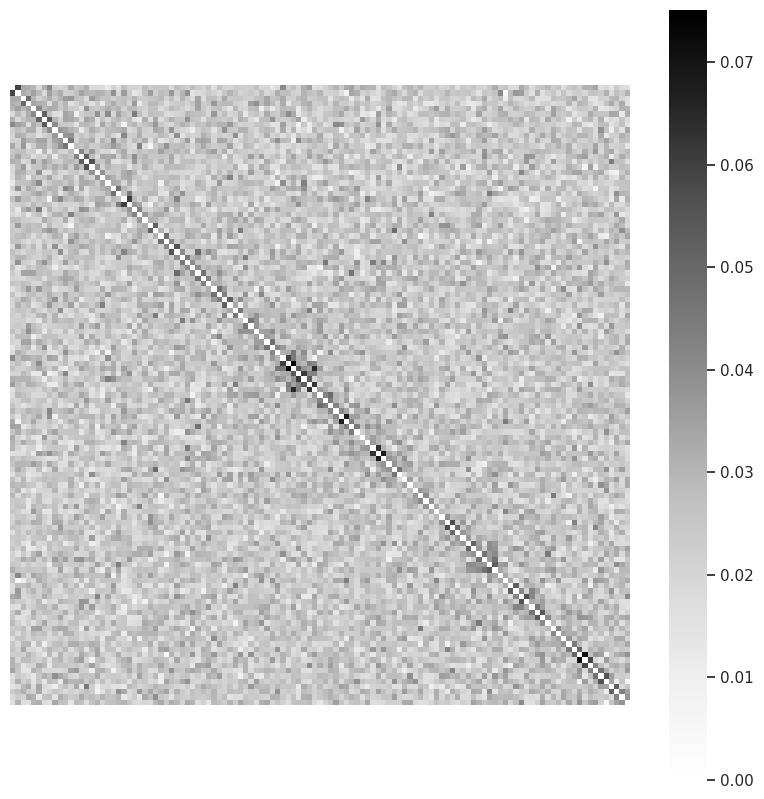

In [15]:
_draw(pseudo_bulk_hic[0], ignore_diag=True)
# Calculate_chromatin_conformation(pseudo_bulk_hic[0]*1000, 'Early')

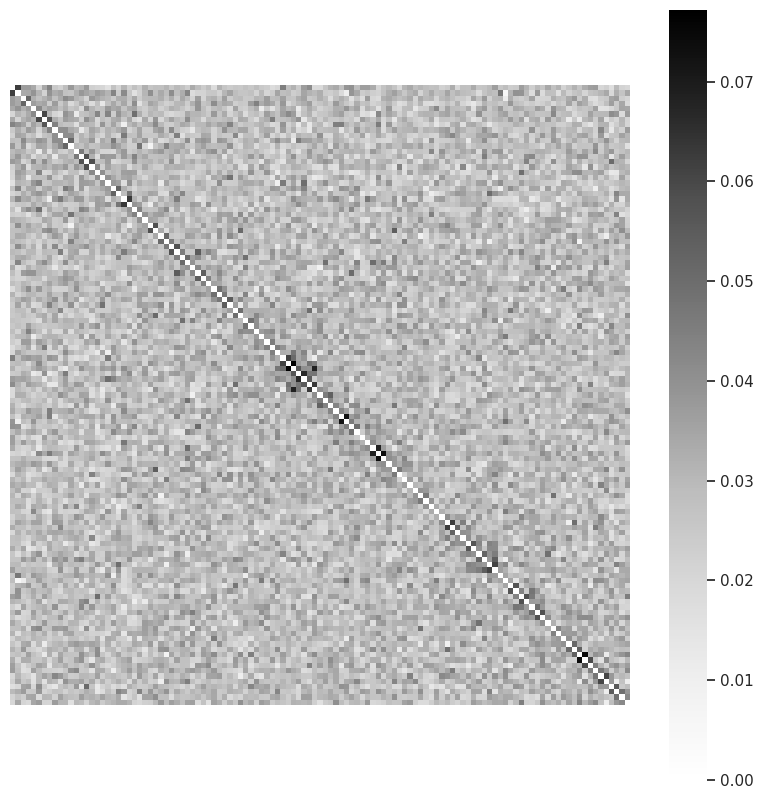

In [16]:
_draw(pseudo_bulk_hic[1], ignore_diag=True)
# Calculate_chromatin_conformation(pseudo_bulk_hic[1]*1000, 'Late')

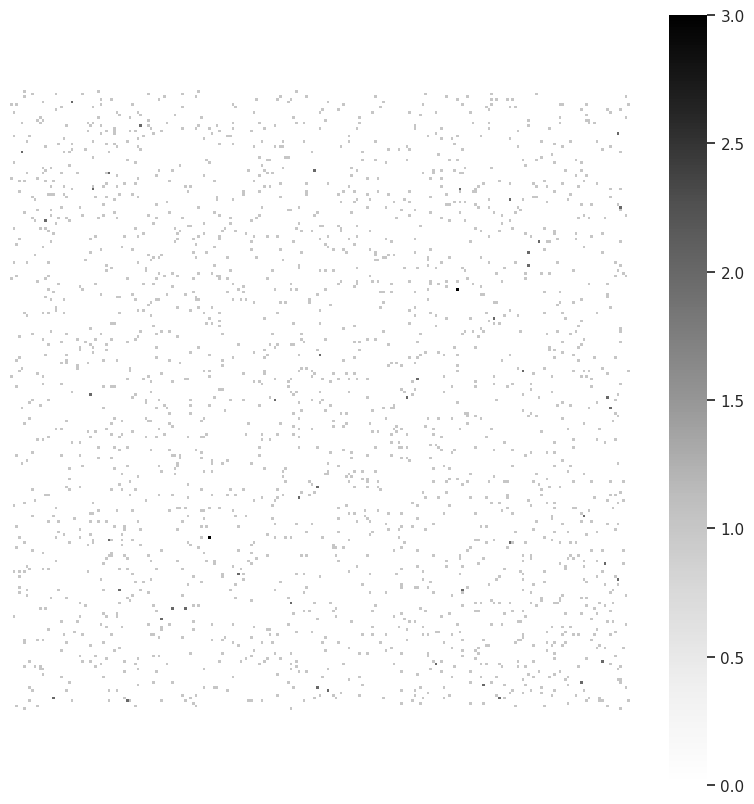

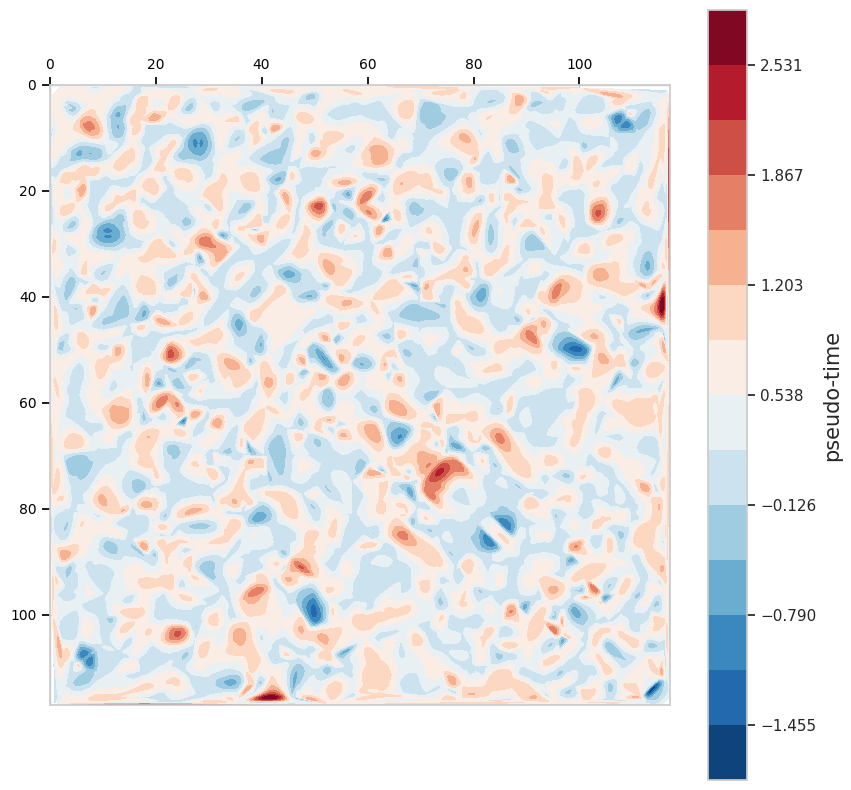

In [17]:
from scipy import interpolate

x = np.linspace(0, _len, _len*2+1)
y = np.linspace(0, _len, _len*2+1)
yy, xx = np.meshgrid(x, y)

def _norm(_decimal):
    if _decimal > 0.5:
        if 1 - _decimal >= _decimal - 0.5:
            return 0.5
        else:
            return 1
    else:
        if 0.5 - _decimal >= _decimal:
            return 0
        else:
            return 0.5

_count = np.zeros(xx.shape)
_value = np.zeros(xx.shape)
for i in range(len(_scatter_xs)):
    _decimal_x, _decimal_y = _scatter_xs[i] - int(_scatter_xs[i]), _scatter_ys[i] - int(_scatter_ys[i])
    _x, _y = int(_scatter_xs[i]) + _norm(_decimal_x), int(_scatter_ys[i]) + _norm(_decimal_y)
    _value[int(_x/0.5), int(_y/0.5)] += _pseudotimes[i]
    _count[int(_x/0.5), int(_y/0.5)] += 1

for i in range(_value.shape[0]):
    for j in range(_value.shape[1]):
        if _count[i, j] != 0:
            _value[i, j] /= _count[i, j]

_value[_count==0] = np.nan
_draw(_count, title='number of interaction occurrences({})'.format(gene_name))




set_plt(figsize=(10, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

xx[_count==0] = yy[_count==0] = np.nan
xx, yy, new_value = xx.ravel(), yy.ravel(), _value.ravel()
xx, yy, new_value = list(xx[~np.isnan(xx)]), list(yy[~np.isnan(yy)]), list(new_value[~np.isnan(new_value)])

xnew = np.linspace(0, _len, _len*10+1)
ynew = np.linspace(0, _len, _len*10+1)
new_value = interpolate.griddata((xx, yy), new_value, (xnew[None,:], ynew[:,None]), method='cubic')

levels = np.linspace(min(new_value[~np.isnan(new_value)]), max(new_value[~np.isnan(new_value)]), 15)
cs = ax.contourf(xnew, ynew, new_value, levels=levels, cmap=plt.cm.RdBu_r)
cbar = plt.colorbar(cs)
cbar.set_label('pseudo-time', rotation=90, fontsize=15) # gas fraction

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')
plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['small'])

plt.savefig(
    '/lmh_data/work/SEE/analyse/figure_file/interactions distribution({}_{}).pdf'.format(gene_name, 'Mb'),
    format='pdf', bbox_inches='tight')

plt.show()

In [18]:
def get_pseudo_bulk_hic(_index):
    _pseudo_bulk = None
    for rna_name in set(np.array(_rna_names)[_index]):
        if rna_name not in scHiC.keys():
            continue

        _hic = array2mat(scHiC[rna_name]).copy()
        _hic += abs(_hic.min())
        if _pseudo_bulk is None:
            _pseudo_bulk = _hic
        else:
            _pseudo_bulk += _hic
    return _pseudo_bulk / len(set(np.array(_rna_names)[_index]))

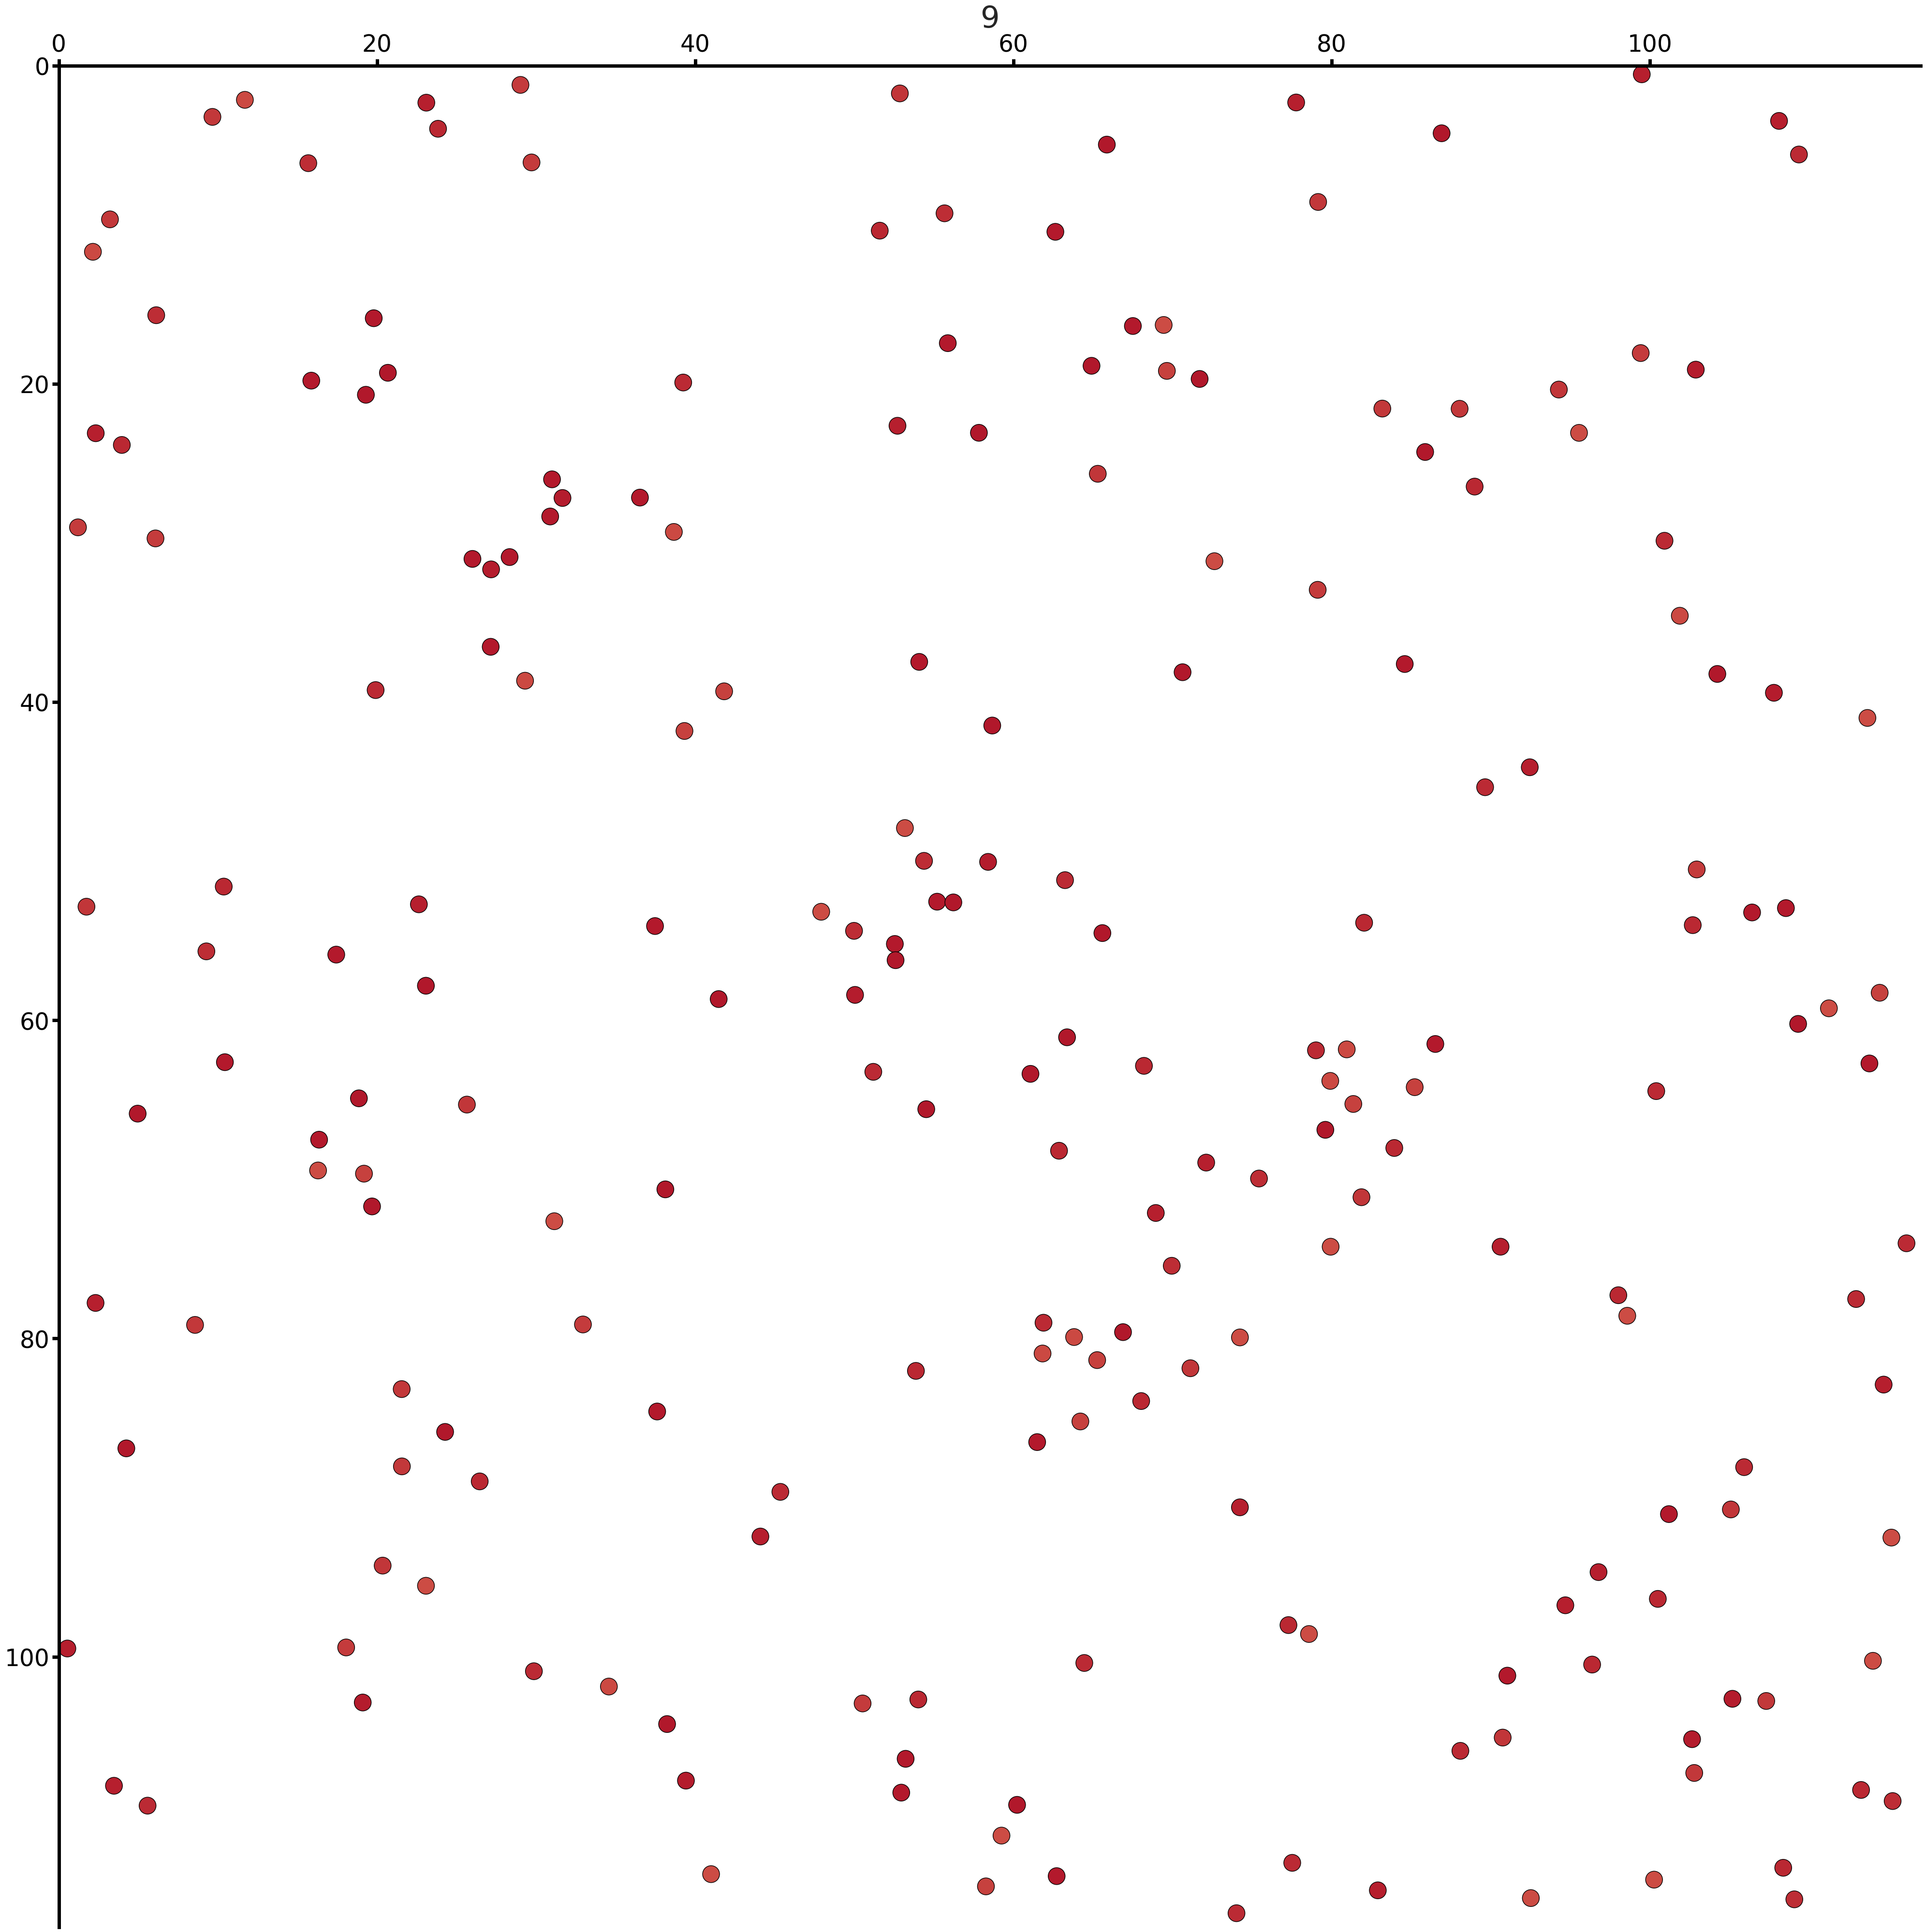

In [19]:
from IPython import display

_array_x, _array_y = np.array(_scatter_xs), np.array(_scatter_ys)
_array_pseudotimes = np.array(_pseudotimes)
_step = 10
for i in range(_step, 100, _step):
    _index = range(int(len(_array_pseudotimes)*(i-_step)/100), int(len(_array_pseudotimes)*(i)/100))
#     _index = np.where(_array_pseudotimes<=i/100)[0]
    if len(_index) == 0:
        continue
        
    set_plt(figsize=(50, 50))
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots()
    set_Border(plt.gca())

    plt.scatter(_array_x[_index], _array_y[_index], edgecolors='black',
            s=(figure_size['large']*72./fig.dpi)**2, c=_array_pseudotimes[_index], cmap='RdBu_r', vmin=0, vmax=1)
    Calculate_chromatin_conformation(get_pseudo_bulk_hic(_index)*1000, './{}_Mb/{}'.format(gene_name, int(i/_step)))

#     plt.xlim((45, 100))
#     plt.ylim((45, 100))
    plt.xlim((0, _len))
    plt.ylim((0, _len))

    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_linewidth(figure_size['very_small'])

    ax.xaxis.set_ticks_position('top')
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_major_locator(MultipleLocator(20))
    
    plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['large'])
    plt.grid(False)
    
    plt.title('{}'.format(int(i/_step)), fontsize=figure_size['ultra'])
#     plt.savefig('/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}_Mb/2D/{}.pdf'.format(gene_name, int(i/_step)),
#                 format='pdf', bbox_inches='tight')
    
    display.clear_output(wait=True)
    plt.pause(0.00000001)

In [20]:
def show_partial(_min, _max):
    _index = np.where((_array_pseudotimes>=_min)&(_array_pseudotimes<=_max))[0]

    set_plt(figsize=(25, 25))
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots()
    set_Border(plt.gca())

    #     ax.scatter(_array_x[_index], _array_y[_index], color='black', s=(figure_size['large']*72./fig.dpi)**2)
    plt.scatter(_array_x[_index], _array_y[_index], edgecolors='black',
            s=(figure_size['large']*72./fig.dpi)**2, c=_array_pseudotimes[_index], cmap='RdBu_r', vmin=0, vmax=1)

#     plt.xlim((0, _len))
#     plt.ylim((0, _len))
    plt.xlim((45, 100))
    plt.ylim((45, 100))

    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_linewidth(figure_size['very_small'])

    ax.xaxis.set_ticks_position('top')
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_major_locator(MultipleLocator(20))

    plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['large'])
    plt.grid(False)

    plt.title('{}~{}'.format(_min, _max), fontsize=figure_size['ultra'])
    
#     plt.savefig(
#         '/lmh_data/work/SEE/analyse/figure_file/{}_{} heatmap({}_{}).pdf'.format(gene_name, 'Mb', _min, _max),
#         format='pdf', bbox_inches='tight')
    plt.show()

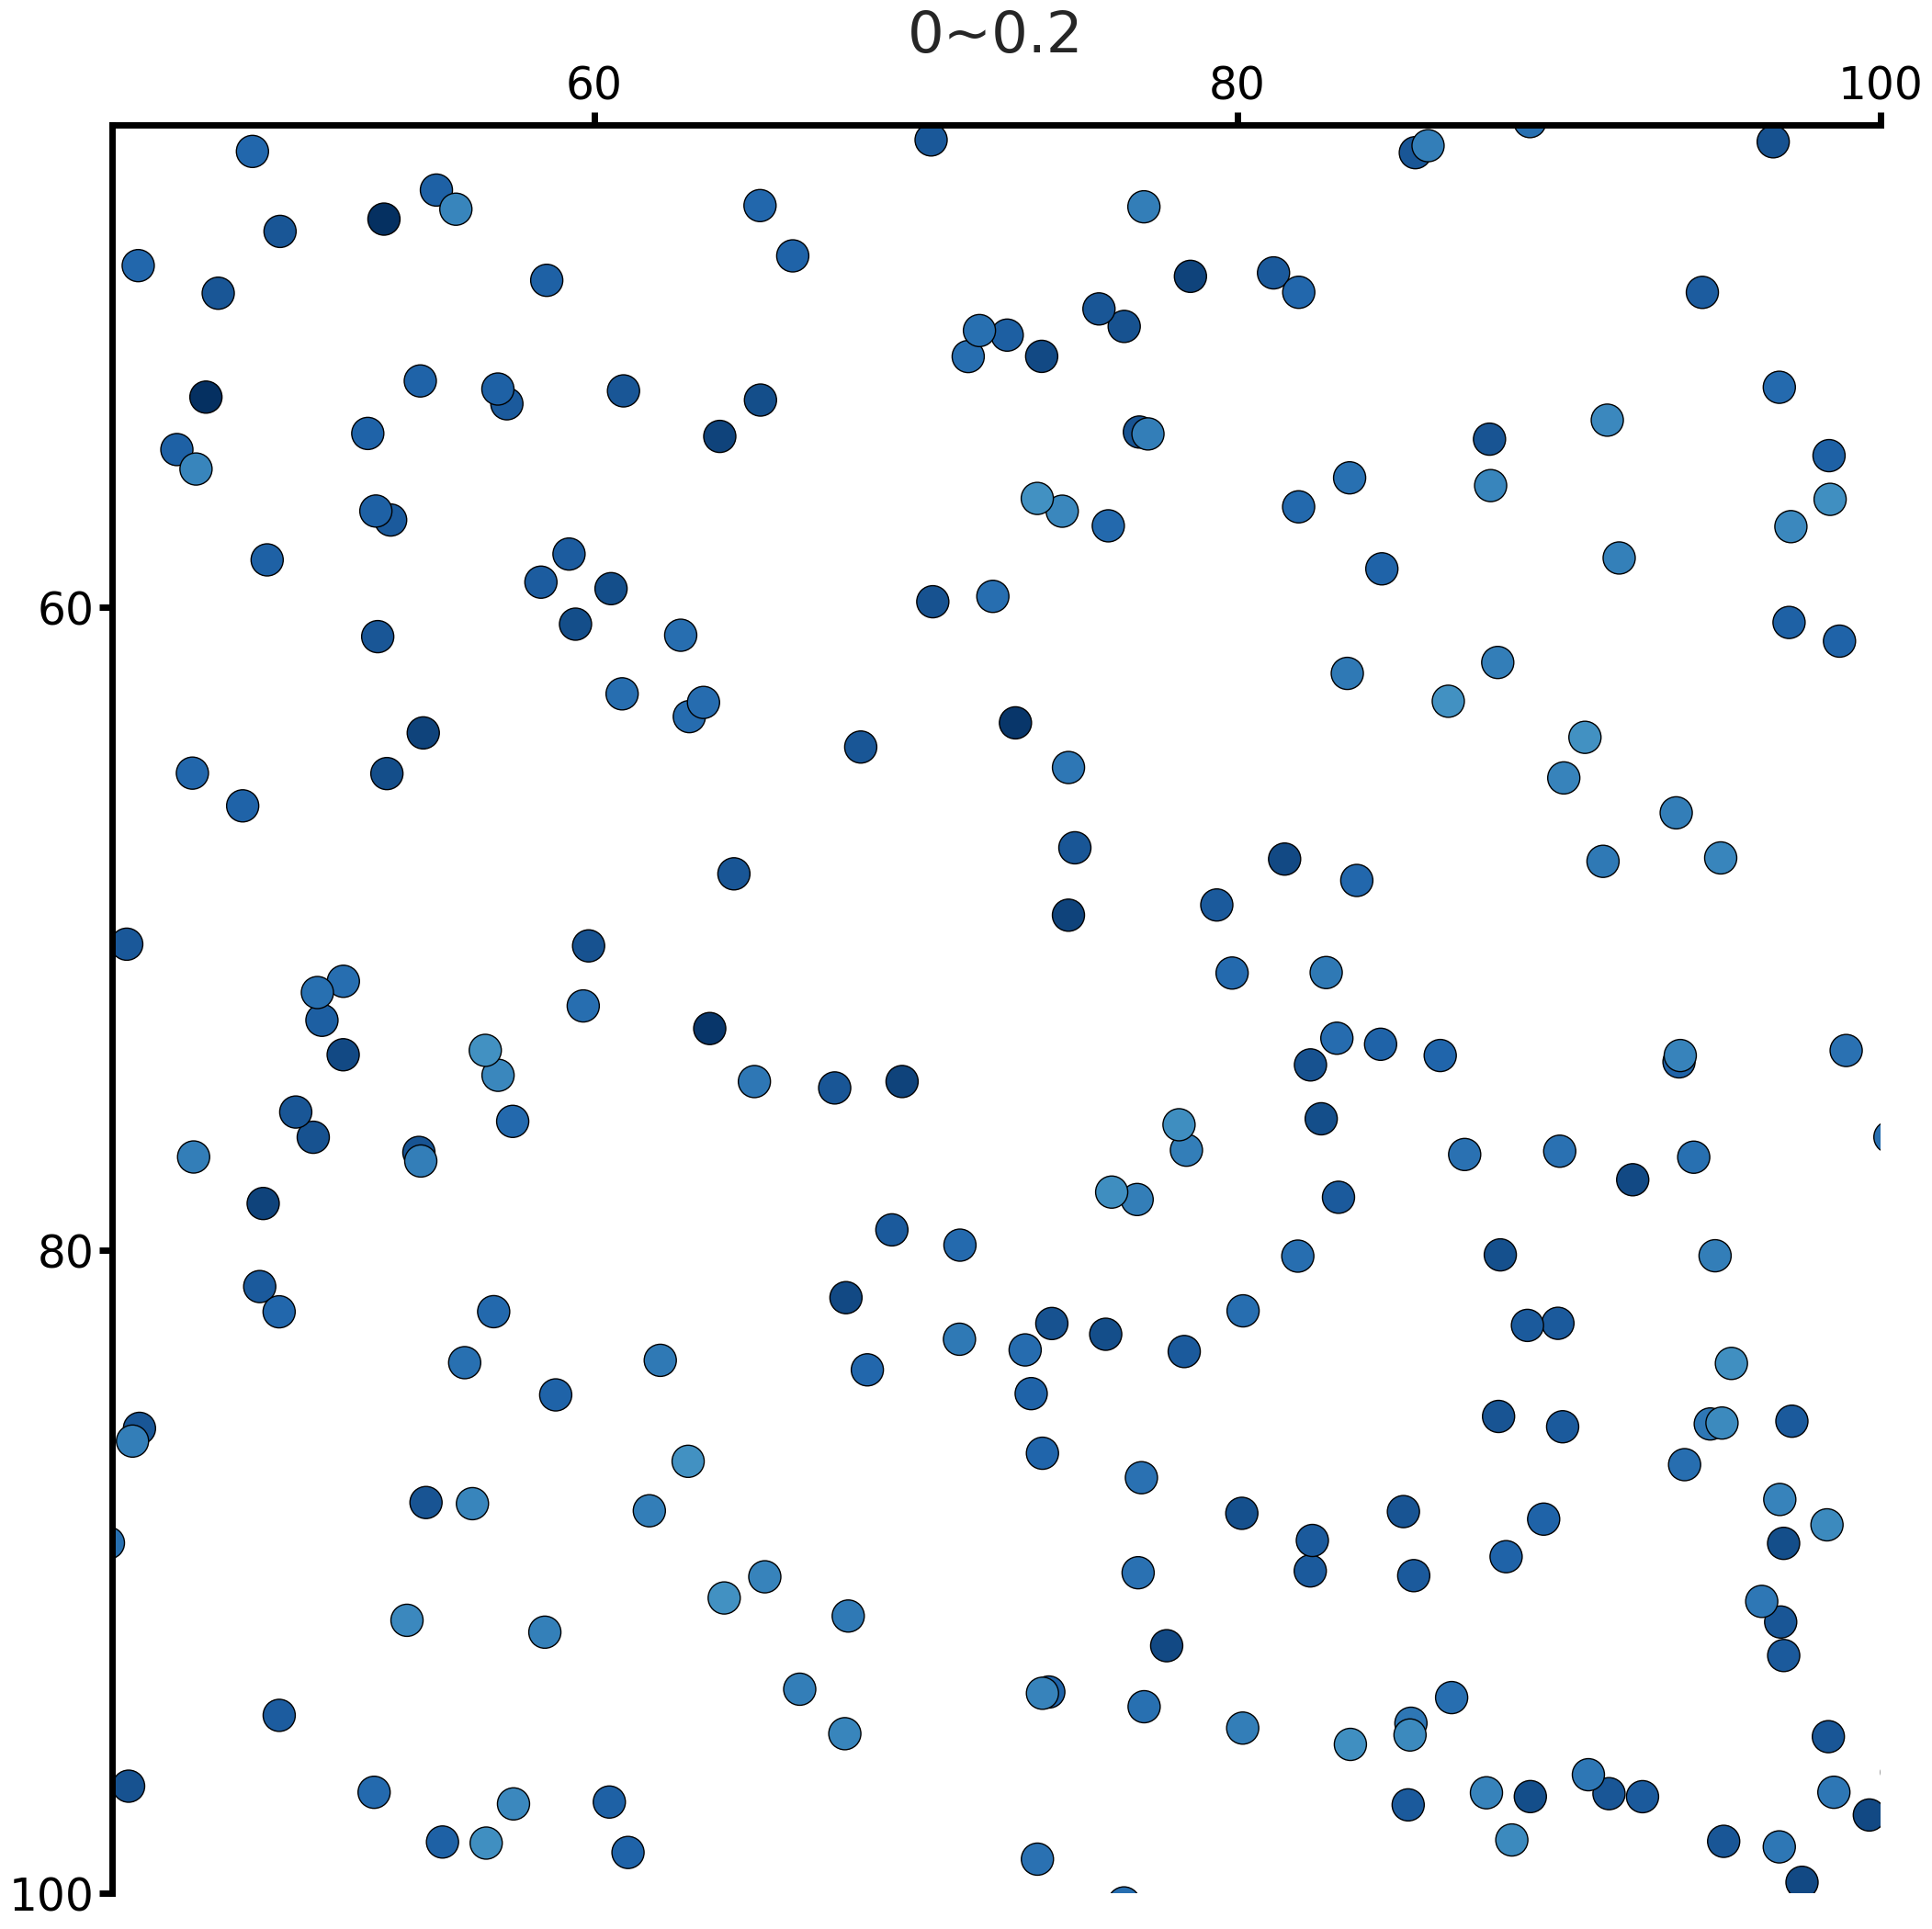

In [21]:
show_partial(0, 0.2)

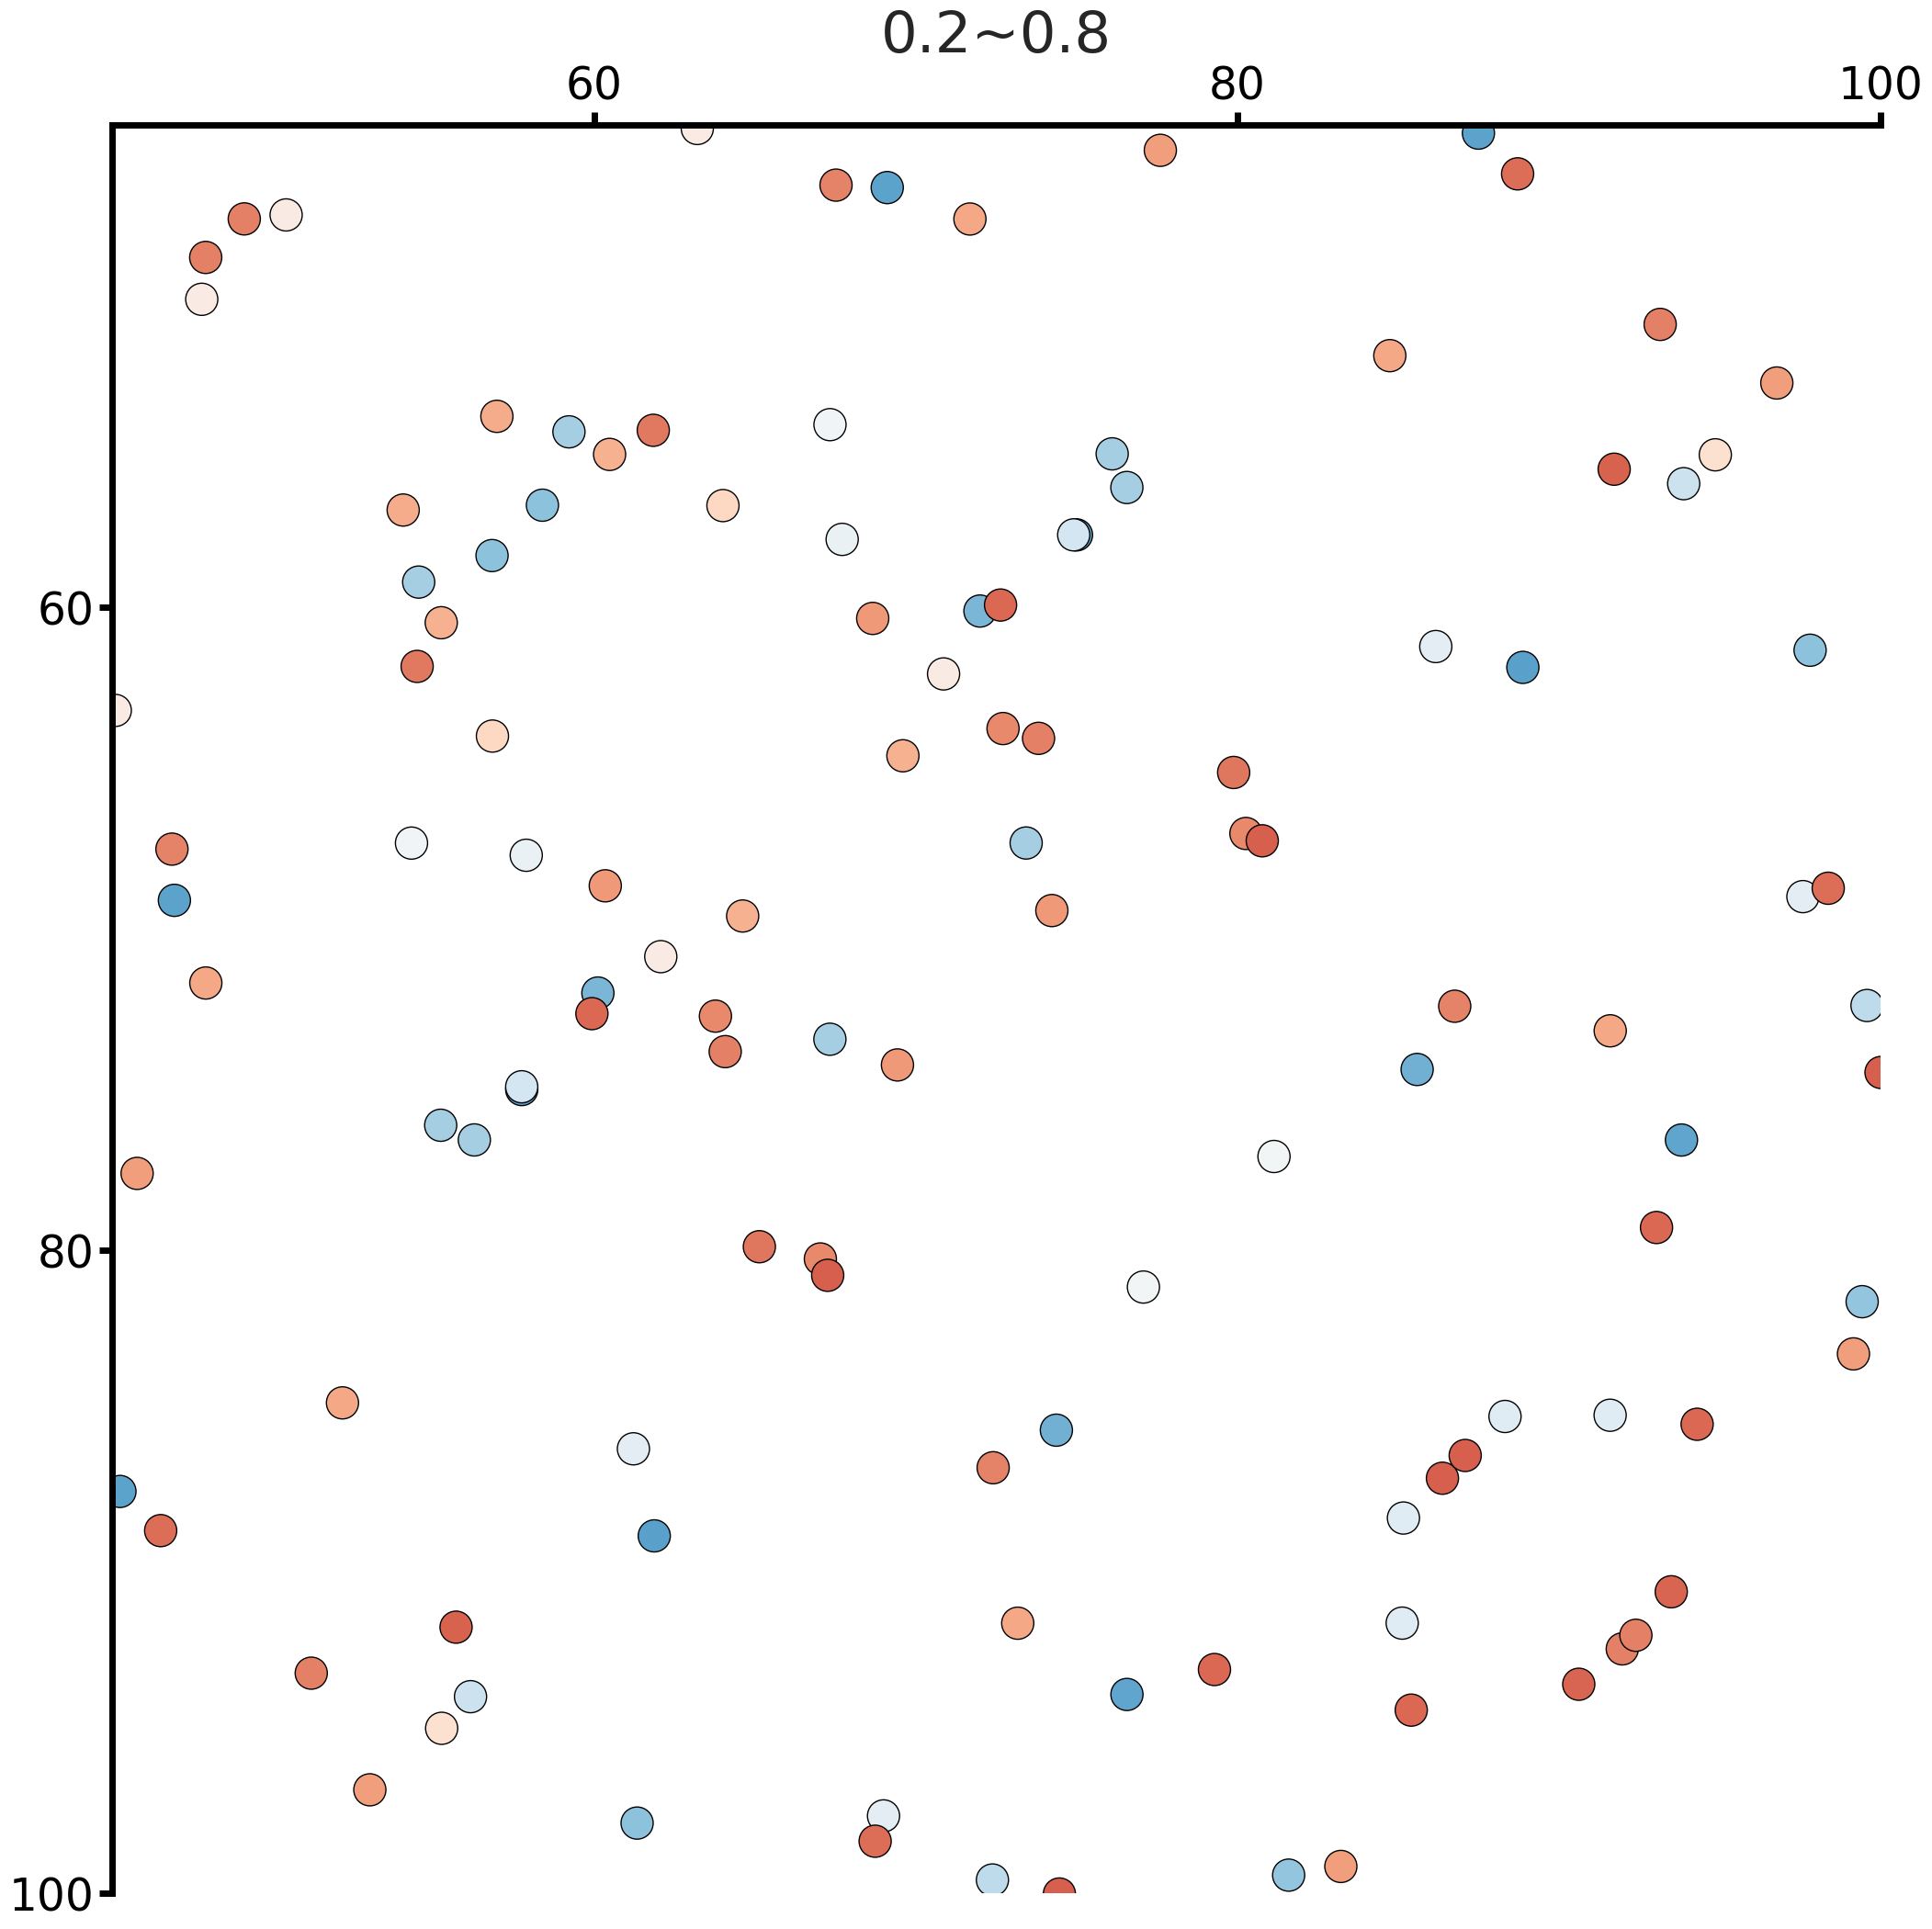

In [22]:
show_partial(0.2, 0.8)

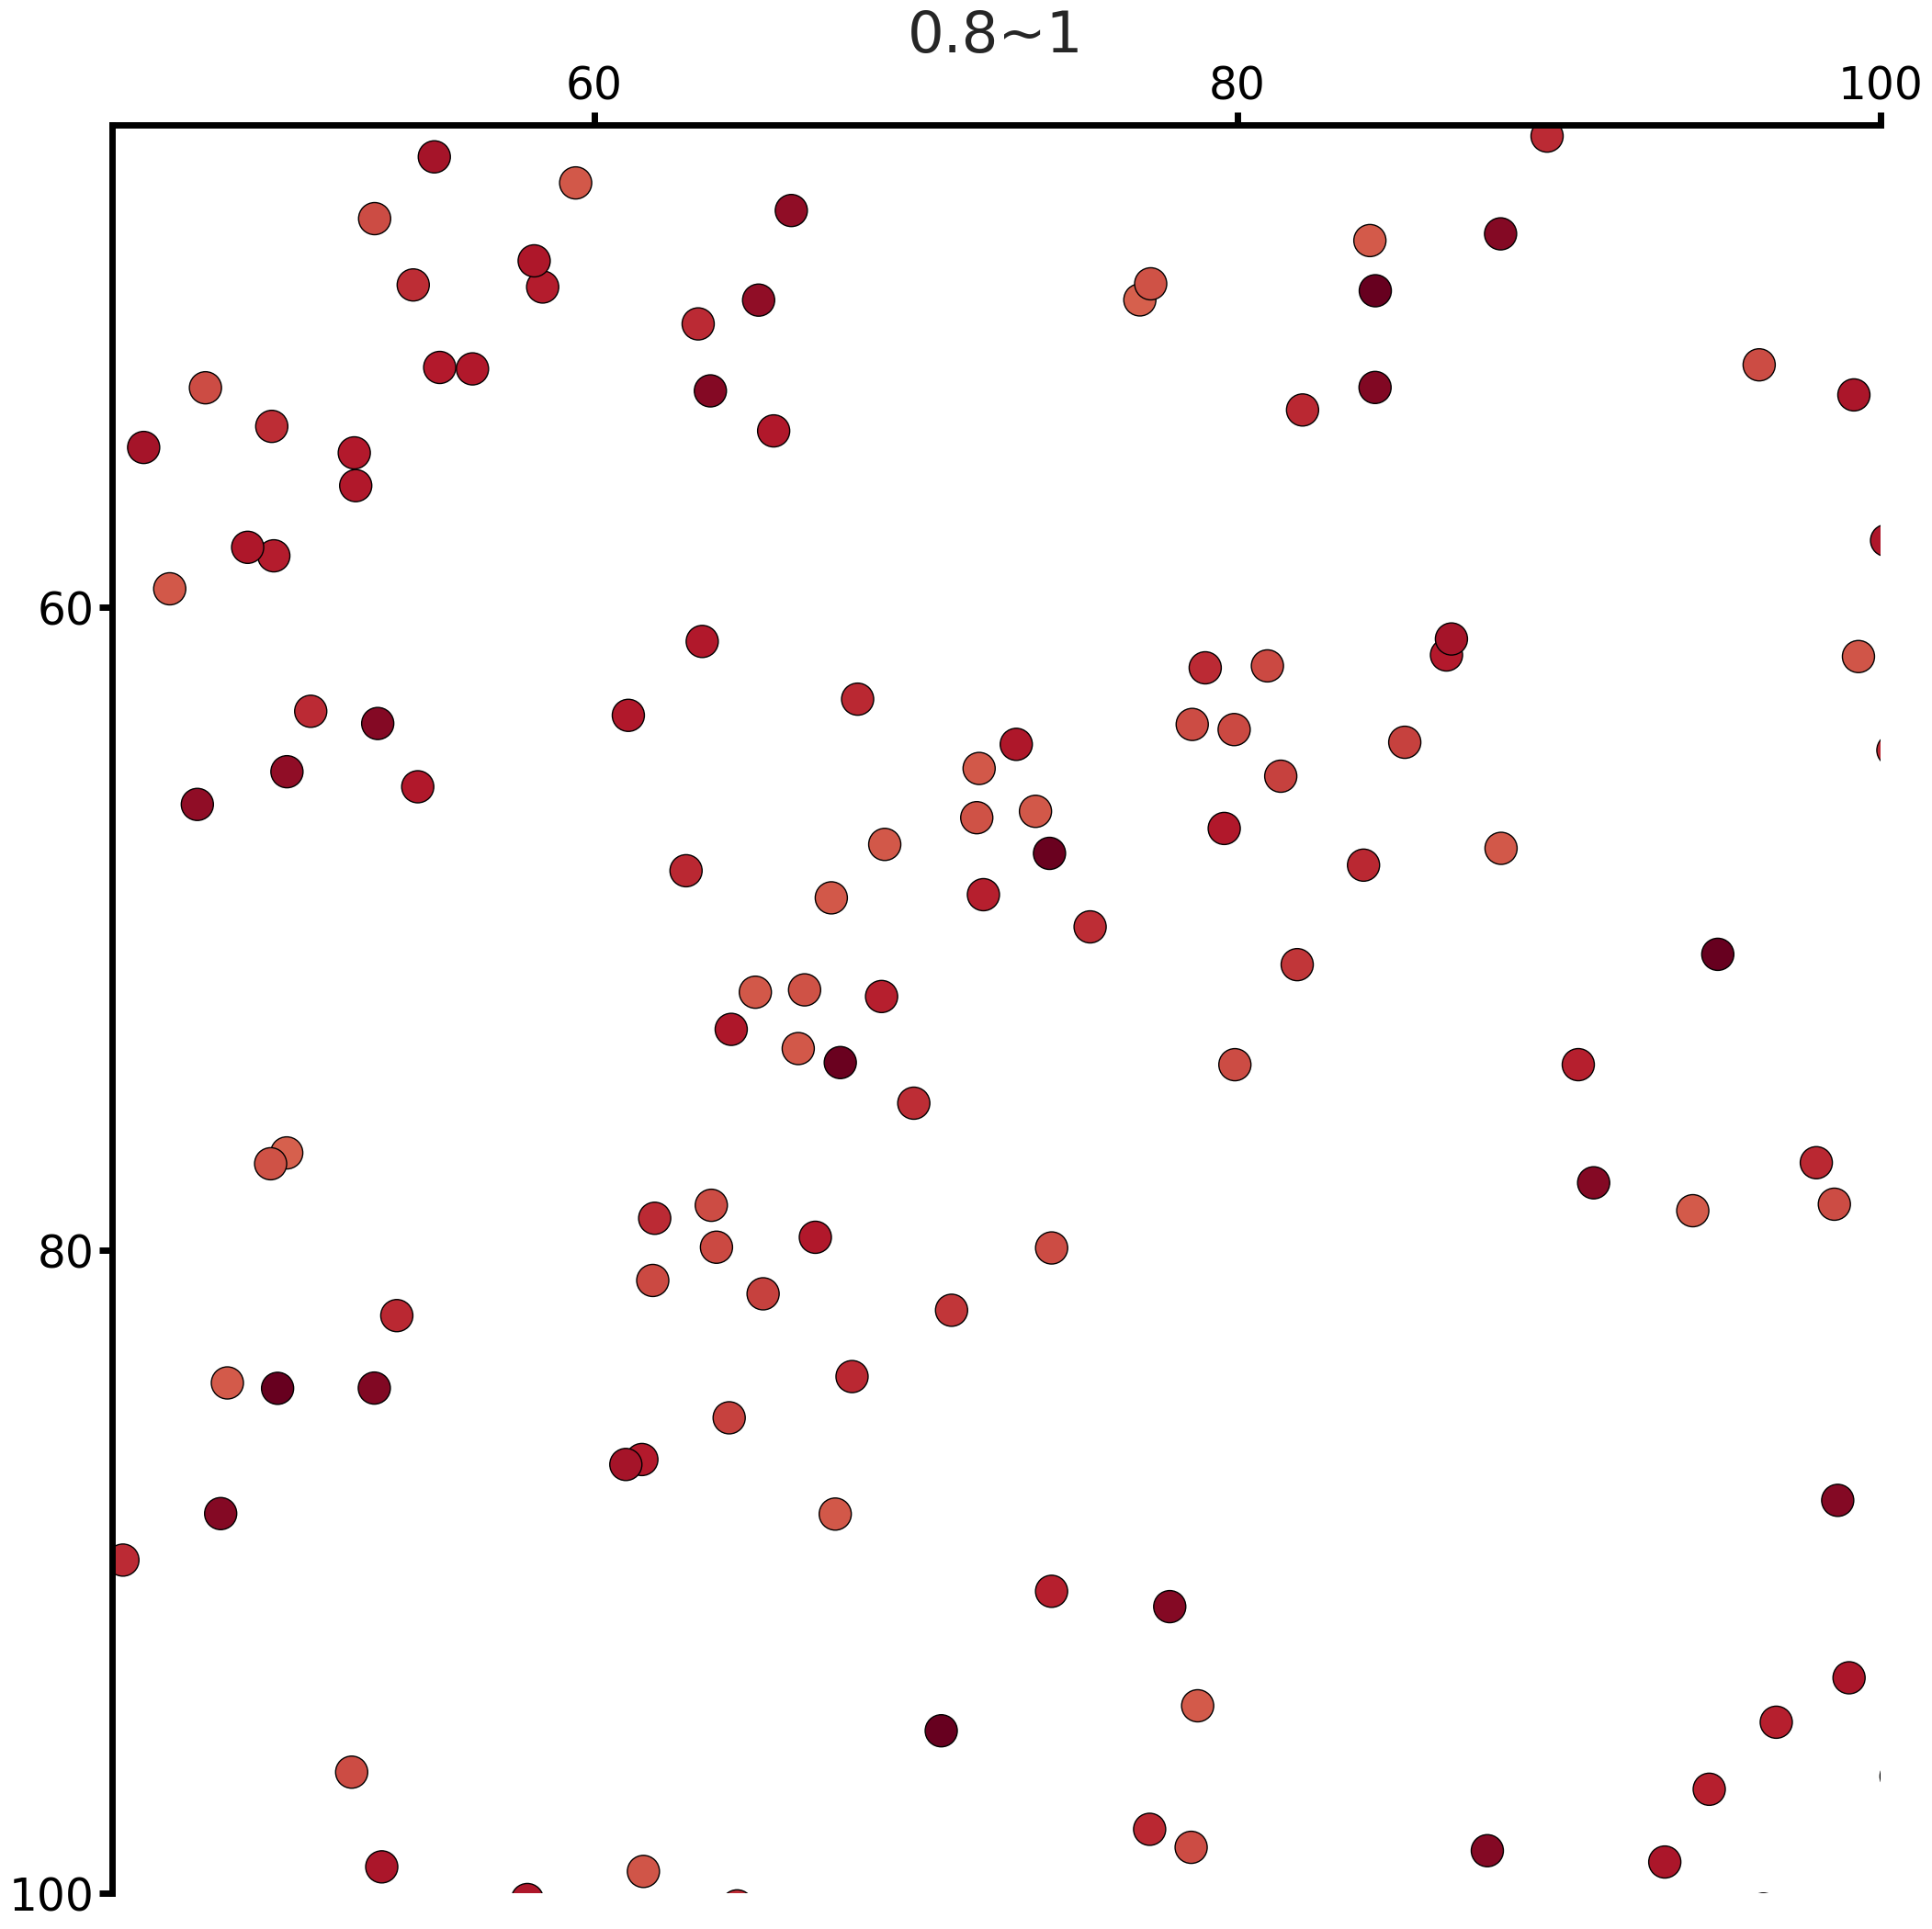

In [23]:
show_partial(0.8, 1)

In [30]:
def get_pseudo_bulk_target_hic(_index):
    _pseudo_bulk = None
    for rna_name in set(np.array(_rna_names)[_index]):
        if rna_name not in target_scHiC.keys():
            continue

        _hic = array2mat(target_scHiC[rna_name]).copy()
        if _pseudo_bulk is None:
            _pseudo_bulk = _hic
        else:
            _pseudo_bulk += _hic
    return _pseudo_bulk / len(set(np.array(_rna_names)[_index]))

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def colorbar_triangle(axm,im,ymax):
    height="2%"
    width="10%"
    if ymax!=None:
        height="6%"
    axins1 = inset_axes(axm, width=width, height=height, loc=4, bbox_to_anchor=(-0.1, 0.7, 1.2, 2.9), bbox_transform=axm.transAxes,)
    cbar=plt.colorbar(im, cax=axins1, orientation='horizontal')
    cbar.ax.xaxis.tick_top()
    cbar.ax.spines['top'].set_color('none')
    cbar.ax.spines['right'].set_color('none')
    cbar.ax.spines['bottom'].set_color('none')
    cbar.ax.spines['left'].set_color('none')


def heatmap_triangle(
    axes, mat, matBalance=False,
    width=6, height=3, cmap=mpl.cm.Greys, showXticks=True, title=None, ymax=None, logData=False
):
    if logData == True:
        mat = np.log2(mat)

    N = mat.shape[1]

    # Transformation matrix for rotating the heatmap.
    A = np.array([(y, x) for x in range(N, -1, -1) for y in range(N + 1)])
    t = np.array([[1,0.5], [-1,0.5]])
    A = np.dot(A, t)

    C = np.triu(mat)

    # This MUST be before the call to pl.pcolormesh() to align properly.
    #axes.set_xticks([])
    axes.set_yticks([])

    # Plot the correlation heatmap triangle.
    X = A[:, 1].reshape(N + 1, N + 1)
    Y = A[:, 0].reshape(N + 1, N + 1)

    #caxes = pl.pcolormesh(X, Y, np.fliplr(C), axes=axes, cmap=cmap, norm=norm)

    #norm=MidpointNormalize(midpoint=0,vmin=-1, vmax=1)
    caxes = axes.pcolormesh(X, Y, np.flipud(C), axes=axes, cmap=cmap, edgecolor='none', snap=True, linewidth=.001)
    #caxes = axes.matshow(np.flipud(C), cmap=cmap, norm=norm)

    # Remove the ticks and reset the x limit.

    axes.set_ylim(bottom=0)
    axes.set_xlim(left=0)
    if ymax != None:
        axes.set_ylim(top=ymax)
    axes.set_title(title)
    
    #set_heatmap_ticks(axes)
    
    axes.axis("off")
#     colorbar_triangle(axes, caxes, ymax)

def show_target_partial(_min, _max):
    _index = np.where((_array_pseudotimes>=_min)&(_array_pseudotimes<=_max))[0]
    _hic = get_pseudo_bulk_target_hic(_index)[50:100, 50:100]

    fig = plt.figure(figsize=(20, 9), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(9, 1)
    ax0 = fig.add_subplot(gs[0:8, 0], facecolor='white')

    row, col = np.diag_indices_from(_hic)
    _diag = _hic[row, col].copy()
    
    _hic[row,col] = 0
    heatmap_triangle(ax0, _hic, width=6, height=2.7, logData=False)
    
#     plt.savefig(
#         'figures/{}_{} heatmap({}_{}).pdf'.format(gene_name, 'Mb', _min, _max),
#         format='pdf', bbox_inches='tight')
    plt.show()

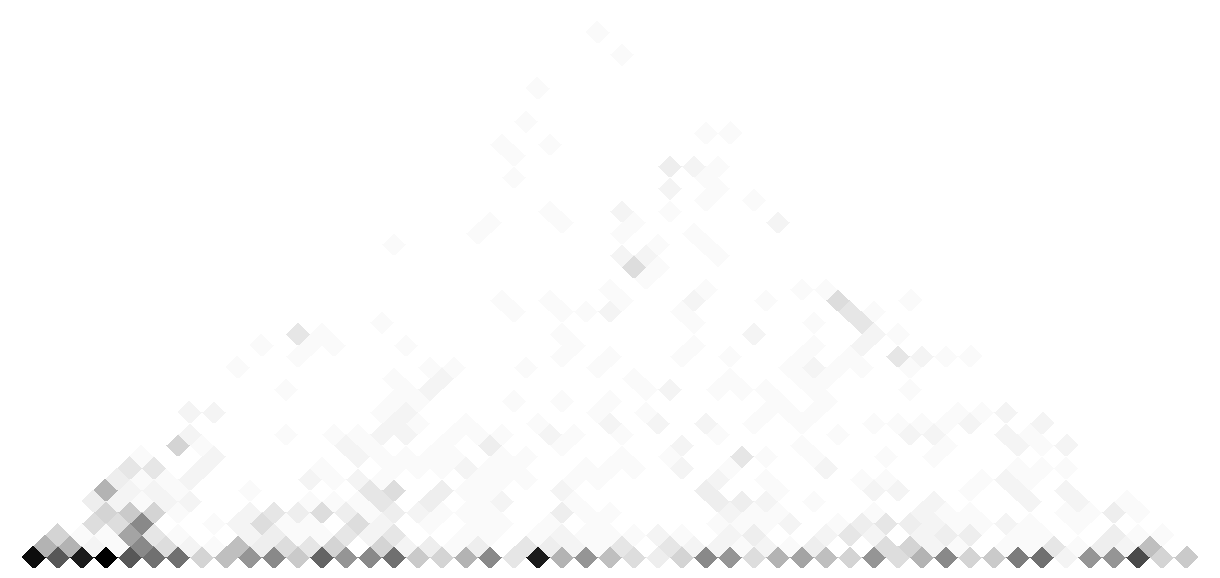

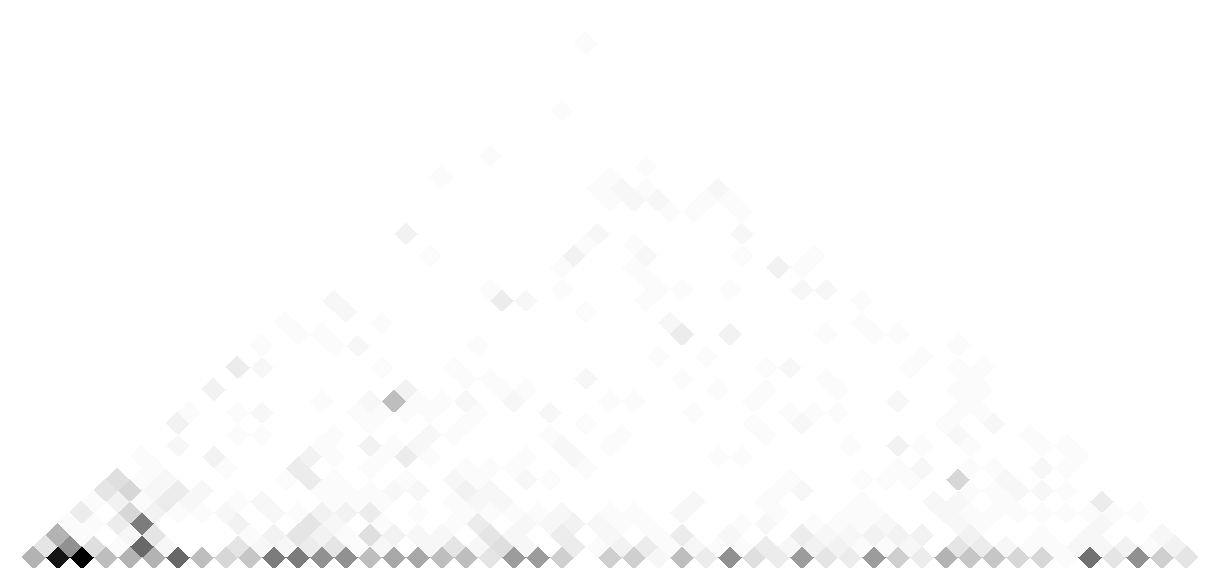

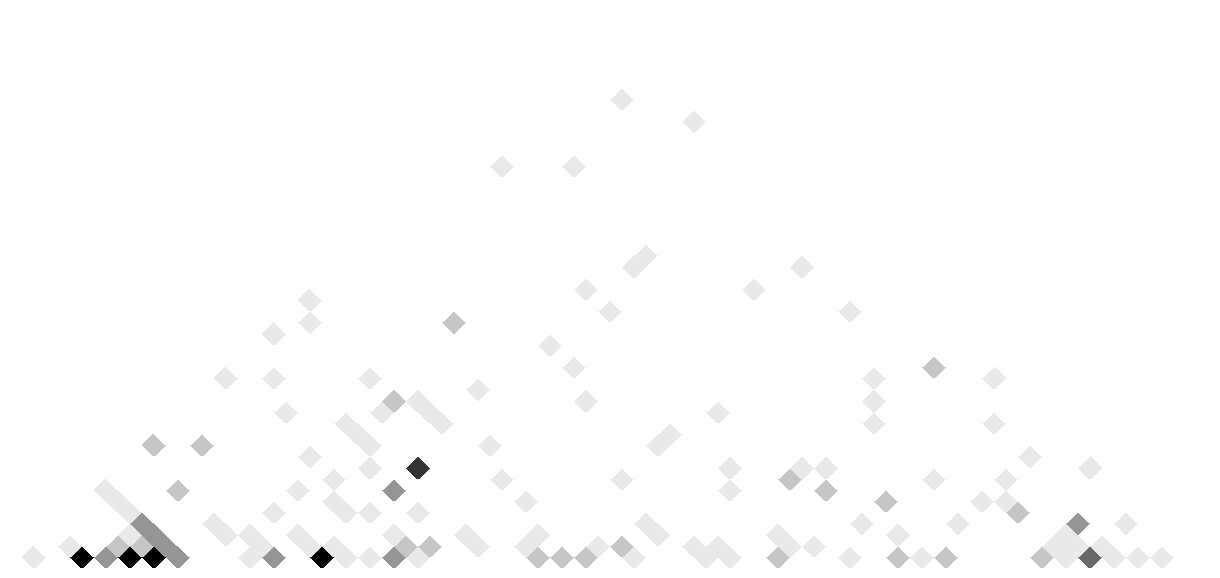

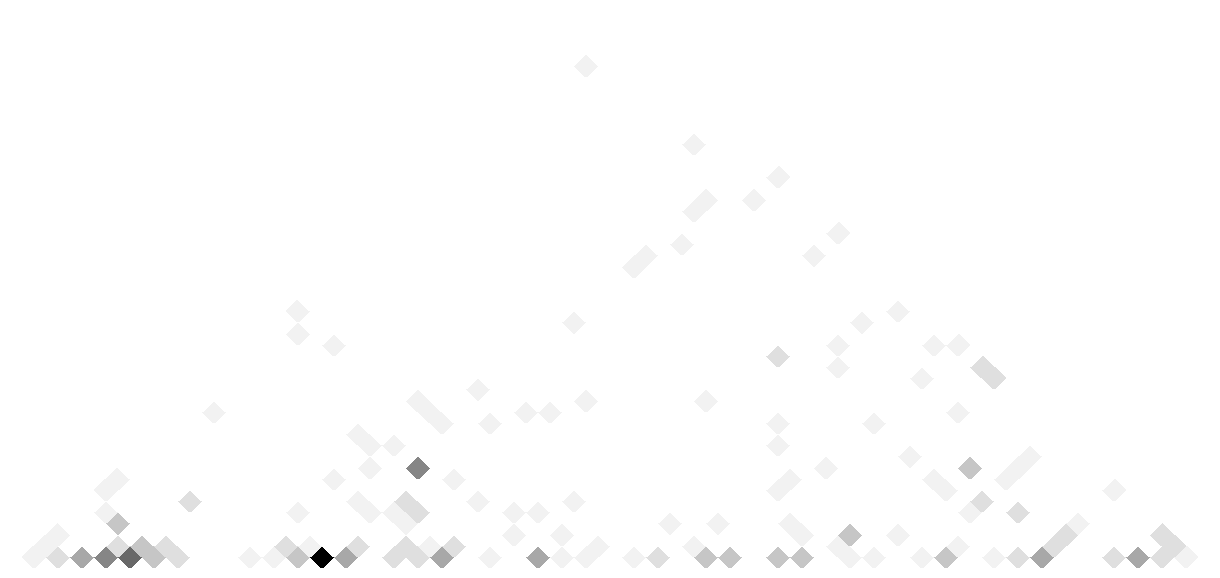

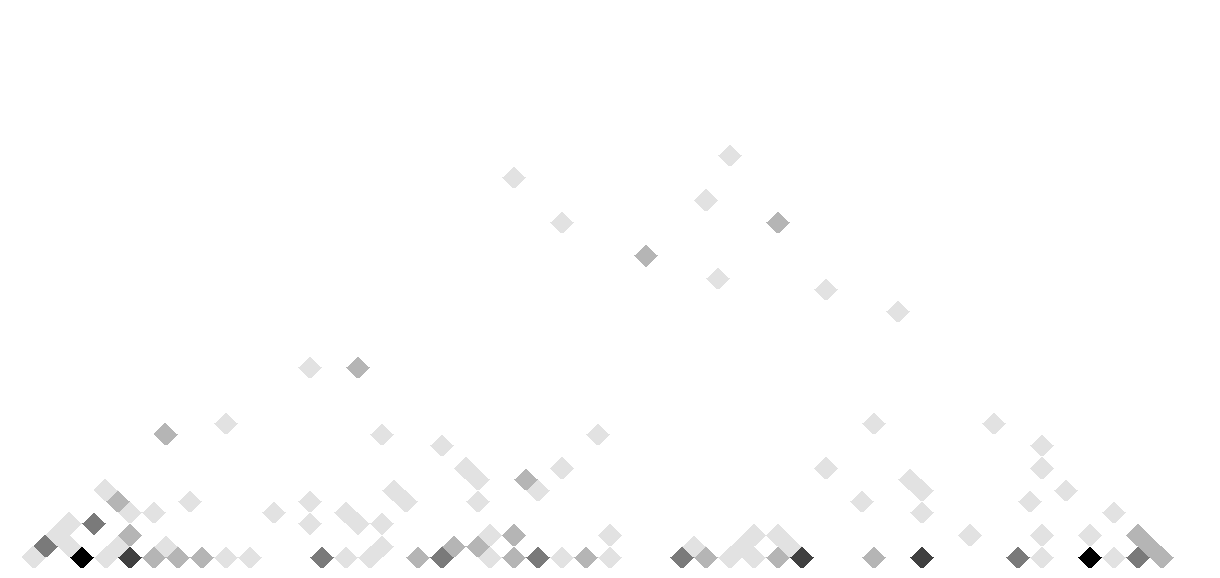

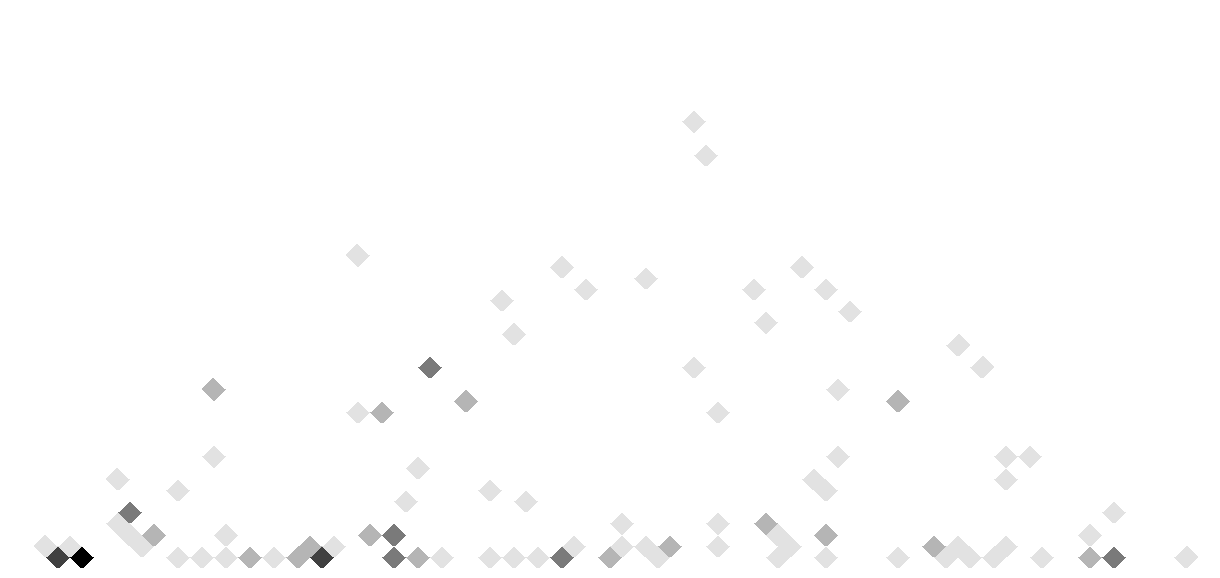

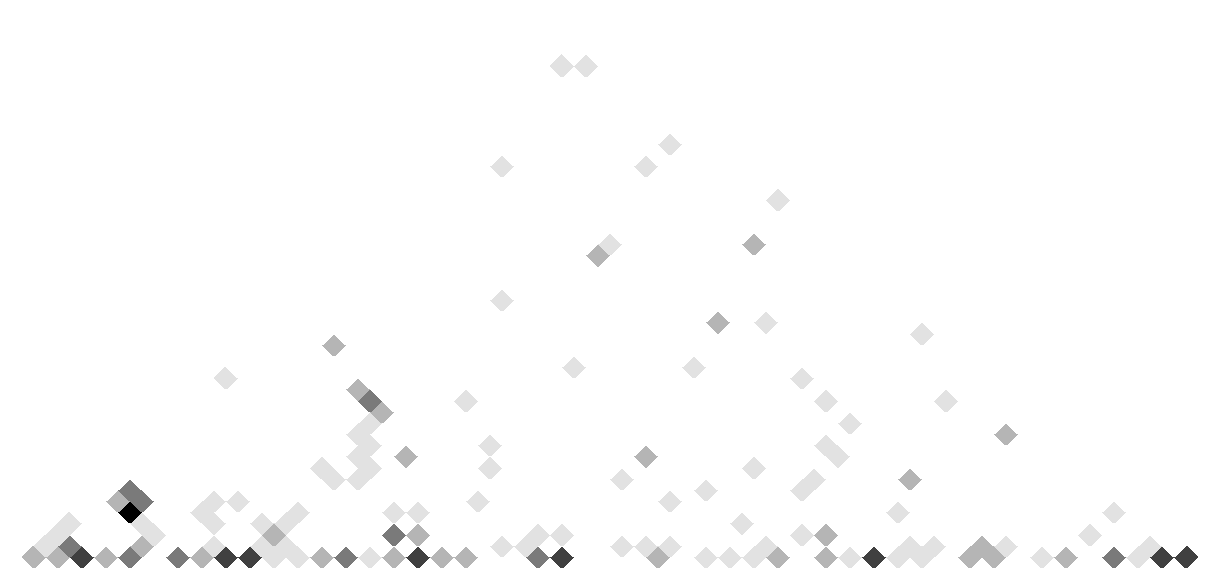

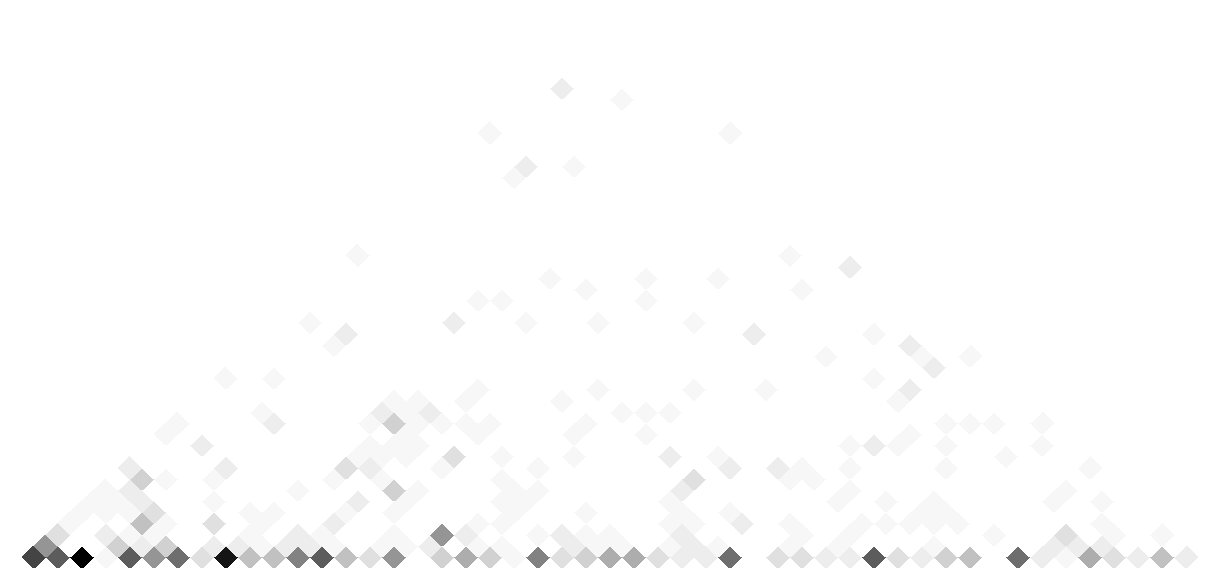

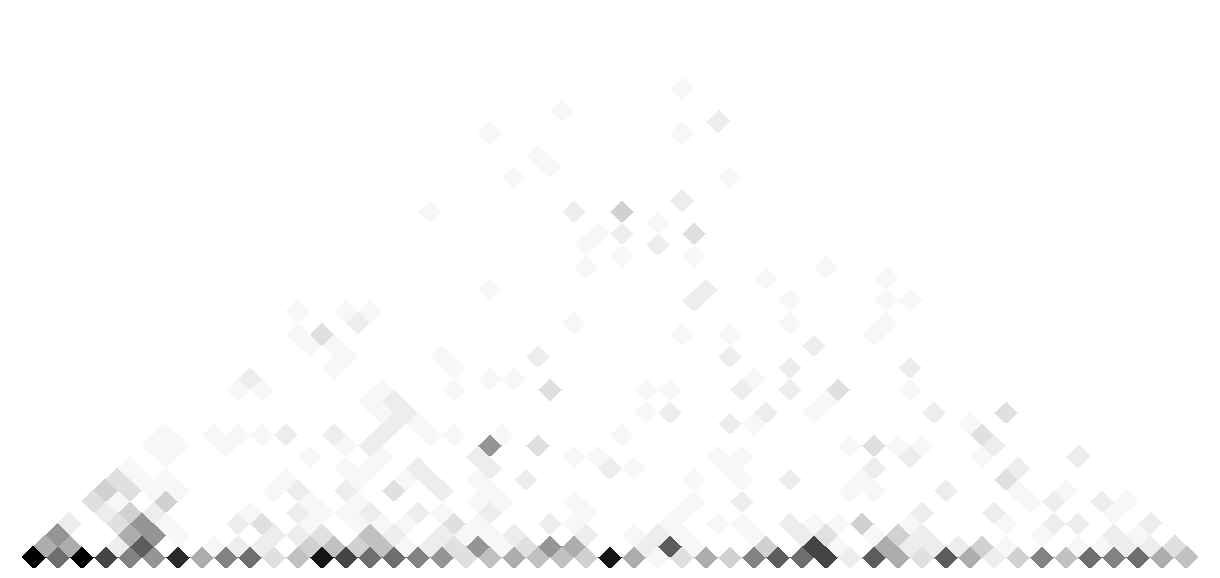

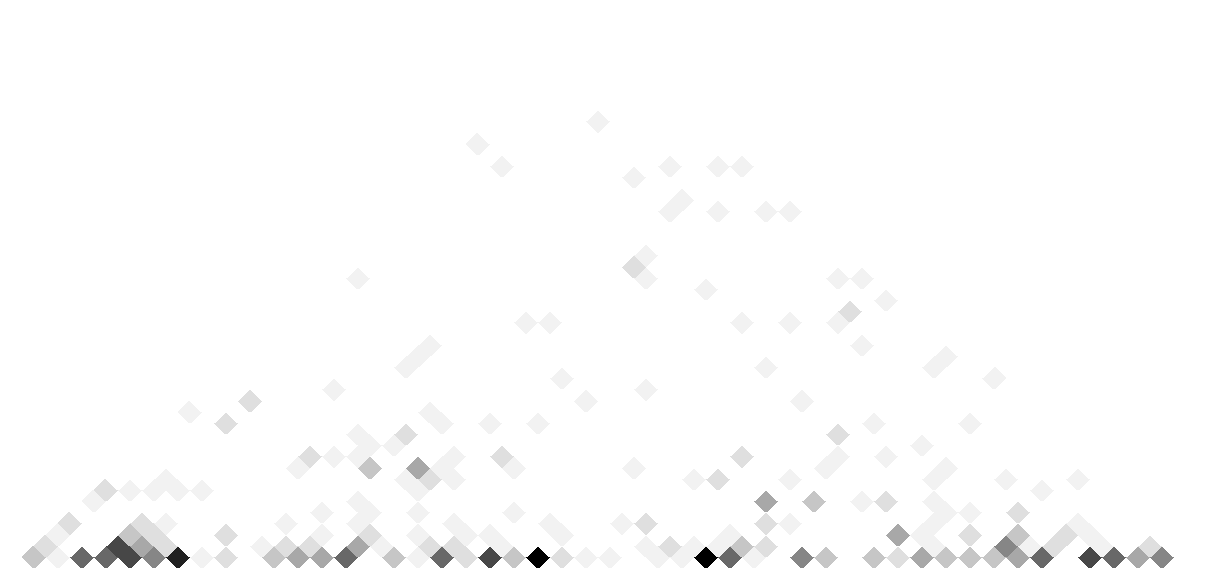

In [36]:
show_target_partial(0, 0.1)
show_target_partial(0.1, 0.2)
show_target_partial(0.2, 0.3)
show_target_partial(0.3, 0.4)
show_target_partial(0.4, 0.5)
show_target_partial(0.5, 0.6)
show_target_partial(0.6, 0.7)
show_target_partial(0.7, 0.8)
show_target_partial(0.8, 0.9)
show_target_partial(0.9, 1)